# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_143635/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_143635/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_143635/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=50)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=50)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-27 17:08:24,531] A new study created in RDB with name: no-name-e279e6c9-c21a-4da0-bcd6-c32ce7207890
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.3910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273,

  0%|          | 1/2000 [00:01<35:27,  1.06s/it]

current_loss: tensor(1.3954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5338, grad_fn=<MeanBackward0>)
current_loss_val:  1.4214942455291748
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4543, grad_fn=<MeanBa

  0%|          | 2/2000 [00:01<28:08,  1.18it/s]

current_loss: tensor(1.3292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4626,

  0%|          | 3/2000 [00:02<25:47,  1.29it/s]

current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5304, grad_fn=<MeanBackward0>)
current_loss_val:  1.415461540222168
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5398, grad_fn=<MeanBac

  0%|          | 4/2000 [00:03<24:47,  1.34it/s]

current_loss: tensor(1.4517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5054, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5311, grad_fn=<MeanBackward0>)
current_loss_val:  1.4140261

  0%|          | 5/2000 [00:05<46:46,  1.41s/it]

current_loss: tensor(1.3464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5329, grad_fn=<MeanBackward0>)
current_loss_val:  1.4126477241516113
current_loss: tensor(1.3355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4260, grad_fn=<MeanBa

  0%|          | 6/2000 [00:09<1:09:47,  2.10s/it]

current_loss: tensor(1.5341, grad_fn=<MeanBackward0>)
current_loss_val:  1.4118887186050415
current_loss: tensor(1.3330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5473, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, grad_fn=<MeanBa

  0%|          | 7/2000 [00:10<1:06:43,  2.01s/it]

current_loss: tensor(1.5070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5349, grad_fn=<MeanBackward0>)
current_loss_val:  1.4116885662078857
current_loss: tensor(1.3303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBa

  0%|          | 8/2000 [00:13<1:09:50,  2.10s/it]

tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5359, grad_fn=<MeanBackward0>)
current_loss_val:  1.410987377166748
current_loss: tensor(1.3304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
curre

  0%|          | 9/2000 [00:15<1:05:49,  1.98s/it]

current_loss: tensor(1.5405, grad_fn=<MeanBackward0>)
current_loss_val:  1.4099438190460205
current_loss: tensor(1.3249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3158, grad_fn=<MeanBa

  0%|          | 10/2000 [00:16<57:08,  1.72s/it] 

current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5382, grad_fn=<MeanBackward0>)
current_loss_val:  1.4098081588745117
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4649, grad_fn=<MeanBa

  1%|          | 11/2000 [00:16<46:31,  1.40s/it]

current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3469,

  1%|          | 12/2000 [00:17<39:40,  1.20s/it]

current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5430, grad_fn=<MeanBackward0>)
current_loss_val:  1.4092146158218384
current_loss: tensor(1.3216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBa

  1%|          | 13/2000 [00:18<34:29,  1.04s/it]

current_loss: tensor(1.4546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5105, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5391,

  1%|          | 14/2000 [00:18<31:04,  1.06it/s]

current_loss: tensor(1.3422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5394, grad_fn=<MeanBackward0>)
current_loss_val:  1.409430980682373
current_loss: tensor(1.3253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4292, grad_fn=<MeanBac

  1%|          | 15/2000 [00:19<28:37,  1.16it/s]

current_loss: tensor(1.3688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5396, grad_fn=<MeanBackward0>)
current_loss_val:  1.4094804525375366
current_loss: tensor(1.3231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4674, grad_fn=<MeanBa

  1%|          | 16/2000 [00:20<27:07,  1.22it/s]

current_loss_val:  1.411155343055725
current_loss: tensor(1.3324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4256, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3156, grad_fn=<MeanBac

  1%|          | 16/2000 [00:21<43:41,  1.32s/it]


current_loss: tensor(1.4165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5352,

  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3256,

  0%|          | 1/2000 [00:01<47:21,  1.42s/it]

current_loss: tensor(1.1954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4078, grad_fn=<MeanBackward0>)
current_loss_val:  1.3702492713928223
current_loss: tensor(1.2058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<47:49,  1.44s/it]

current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4113, grad_fn=<MeanBackward0>)
current_loss_val:  1.3575663566589355
current_loss: tensor(1.2111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3614, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<47:17,  1.42s/it]

current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3976, grad_fn=<MeanBackward0>)
current_loss_val:  1.3764488697052002
current_loss: tensor(1.1916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2982, grad_fn=<MeanBa

  0%|          | 4/2000 [00:05<47:46,  1.44s/it]

current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4037, grad_fn=<MeanBackward0>)
current_loss_val:  1.3846849203109741
current_loss: tensor(1.2058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBa

  0%|          | 5/2000 [00:07<47:49,  1.44s/it]

current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, grad_fn=<MeanBackward0>)
current_loss_val:  1.387393832206726
current_loss: tensor(1.1974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2061, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2115, grad_fn=<MeanBac

  0%|          | 6/2000 [00:08<47:53,  1.44s/it]

current_loss: tensor(1.4012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3954, grad_fn=<MeanBackward0>)
current_loss_val:  1.3723405599594116
current_loss: tensor(1.1885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2163, grad_fn=<MeanBa

  0%|          | 6/2000 [00:10<56:28,  1.70s/it]

current_loss: tensor(1.3809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, grad_fn=<MeanBackward0>)
current_loss_val:  1.3736118078231812
Early Stop at iteration 6 with minimal loss tensor(1.3576) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:08:59,099] Trial 0 finished with value: -2.5464470982551575 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.565537490949405, 'penalty_decorrelation_ridge_second_difference': 1.0129298378628733}. Best is trial 0 with value: -2.5464470982551575.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3211,

  0%|          | 1/2000 [00:01<50:32,  1.52s/it]

current_loss: tensor(1.4170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4056, grad_fn=<MeanBackward0>)
current_loss_val:  1.3644204139709473
current_loss: tensor(1.2057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2993, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<50:03,  1.50s/it]

current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3971, grad_fn=<MeanBackward0>)
current_loss_val:  1.3696078062057495
current_loss: tensor(1.1966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2027, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<49:35,  1.49s/it]

current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, grad_fn=<MeanBackward0>)
current_loss_val:  1.3642982244491577
current_loss: tensor(1.1966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:03:43,  1.92s/it]

current_loss: tensor(1.4037, grad_fn=<MeanBackward0>)
current_loss_val:  1.3768928050994873
current_loss: tensor(1.1868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2084, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:58:14,  3.56s/it]

current_loss: tensor(1.2737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4006, grad_fn=<MeanBackward0>)
current_loss_val:  1.3747689723968506
current_loss: tensor(1.1849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, grad_fn=<MeanBa

  0%|          | 6/2000 [00:18<2:08:58,  3.88s/it]

current_loss: tensor(1.3759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4044, grad_fn=<MeanBackward0>)
current_loss_val:  1.3862566947937012
current_loss: tensor(1.1854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, grad_fn=<MeanBa

  0%|          | 7/2000 [00:19<1:48:03,  3.25s/it]

current_loss: tensor(1.2053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3980, grad_fn=<MeanBackward0>)
current_loss_val:  1.3799102306365967
current_loss: tensor(1.1720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1809, grad_fn=<MeanBa

  0%|          | 7/2000 [00:21<1:41:38,  3.06s/it]

current_loss: tensor(1.3939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3978, grad_fn=<MeanBackward0>)
current_loss_val:  1.3785406351089478
Early Stop at iteration 7 with minimal loss tensor(1.3643) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:09:21,542] Trial 1 finished with value: -2.5286944687366484 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.96873530761529, 'penalty_decorrelation_ridge_second_difference': 6.746854647408776}. Best is trial 1 with value: -2.5286944687366484.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(2.2565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985,

  0%|          | 1/2000 [00:01<52:10,  1.57s/it]

current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3735, grad_fn=<MeanBackward0>)
current_loss_val:  1.3803671598434448
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2051, grad_fn=<MeanBackward0>)
current_loss: tensor(2.3833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<50:52,  1.53s/it]

current_loss: tensor(1.3523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3752, grad_fn=<MeanBackward0>)
current_loss_val:  1.375882863998413
current_loss: tensor(1.1747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3335, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1750, grad_fn=<MeanBac

  0%|          | 3/2000 [00:04<50:26,  1.52s/it]

current_loss: tensor(1.2203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss_val:  1.4037302732467651
current_loss: tensor(1.1674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1876, grad_fn=<MeanBa

  0%|          | 4/2000 [00:08<1:21:39,  2.45s/it]

current_loss_val:  1.3760333061218262
current_loss: tensor(1.1628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3140, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2293, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<2:09:01,  3.88s/it]

current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3711, grad_fn=<MeanBackward0>)
current_loss_val:  1.3864364624023438
current_loss: tensor(1.1620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3156, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1860, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3078, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, grad_fn=<MeanBa

  0%|          | 6/2000 [00:19<2:15:22,  4.07s/it]

current_loss: tensor(1.3457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3742, grad_fn=<MeanBackward0>)
current_loss_val:  1.3786343336105347
current_loss: tensor(1.1549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, grad_fn=<MeanBa

  0%|          | 6/2000 [00:22<2:02:29,  3.69s/it]

current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss_val:  1.379348874092102
Early Stop at iteration 6 with minimal loss tensor(1.3759) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:09:44,718] Trial 2 finished with value: -2.5019510090351105 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6008407042162909, 'penalty_decorrelation_ridge_second_difference': 1.2032238777610447}. Best is trial 2 with value: -2.5019510090351105.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155,

  0%|          | 1/2000 [00:01<50:05,  1.50s/it]

current_loss: tensor(1.4134, grad_fn=<MeanBackward0>)
current_loss_val:  1.3635119199752808
current_loss: tensor(1.2104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2197, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<48:23,  1.45s/it]

current_loss: tensor(1.2282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, grad_fn=<MeanBackward0>)
current_loss_val:  1.3587827682495117
current_loss: tensor(1.2100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, grad_fn=<MeanBackward0>)
current_loss: tensor(2.9705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:18,  1.45s/it]

current_loss: tensor(1.2107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4073, grad_fn=<MeanBackward0>)
current_loss_val:  1.365264892578125
current_loss: tensor(1.1990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2046, grad_fn=<MeanBac

  0%|          | 4/2000 [00:07<1:09:32,  2.09s/it]

current_loss: tensor(1.4080, grad_fn=<MeanBackward0>)
current_loss_val:  1.3661304712295532
current_loss: tensor(1.2023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3136, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2148, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<2:03:58,  3.73s/it]

current_loss: tensor(1.4122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4033, grad_fn=<MeanBackward0>)
current_loss_val:  1.3723061084747314
current_loss: tensor(1.1936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2846, grad_fn=<MeanBa

  0%|          | 6/2000 [00:18<2:10:06,  3.92s/it]

current_loss: tensor(1.4048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4026, grad_fn=<MeanBackward0>)
current_loss_val:  1.371767520904541
current_loss: tensor(1.1909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1897, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, grad_fn=<MeanBac

  0%|          | 6/2000 [00:20<1:54:17,  3.44s/it]

current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, grad_fn=<MeanBackward0>)
current_loss_val:  1.3695755004882812
Early Stop at iteration 6 with minimal loss tensor(1.3588) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:10:06,306] Trial 3 finished with value: -2.5522674560546874 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.250829996228592, 'penalty_decorrelation_ridge_second_difference': 16.417074387166256}. Best is trial 2 with value: -2.5019510090351105.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3229,

  0%|          | 1/2000 [00:01<52:02,  1.56s/it]

current_loss: tensor(1.3544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3867, grad_fn=<MeanBackward0>)
current_loss_val:  1.3738425970077515
current_loss: tensor(1.1818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3295, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<50:26,  1.51s/it]

current_loss: tensor(1.3561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss_val:  1.3829050064086914
current_loss: tensor(1.1765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<49:24,  1.48s/it]

current_loss: tensor(1.3477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<MeanBackward0>)
current_loss_val:  1.3725385665893555
current_loss: tensor(1.1735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3235, grad_fn=<MeanBa

  0%|          | 4/2000 [00:08<1:25:25,  2.57s/it]

current_loss: tensor(1.4099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3788, grad_fn=<MeanBackward0>)
current_loss_val:  1.3662688732147217
current_loss: tensor(1.1724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3174, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2062, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<2:04:57,  3.76s/it]

current_loss: tensor(1.4764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3810, grad_fn=<MeanBackward0>)
current_loss_val:  1.3694554567337036
current_loss: tensor(1.1654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1800, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBa

  0%|          | 6/2000 [00:18<2:04:48,  3.76s/it]

current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<MeanBackward0>)
current_loss_val:  1.3727707862854004
current_loss: tensor(1.1658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, grad_fn=<MeanBa

  0%|          | 7/2000 [00:21<1:56:31,  3.51s/it]

current_loss_val:  1.3782920837402344
current_loss: tensor(1.1687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1875, grad_fn=<MeanBackward0>)
current_loss: tensor(3.4544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3166, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, grad_fn=<MeanBa

  0%|          | 8/2000 [00:22<1:35:54,  2.89s/it]

current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss_val:  1.3817962408065796
current_loss: tensor(1.1557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, grad_fn=<MeanBa

  0%|          | 8/2000 [00:24<1:41:07,  3.05s/it]

current_loss: tensor(1.3464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss_val:  1.3791625499725342
Early Stop at iteration 8 with minimal loss tensor(1.3663) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:10:31,651] Trial 4 finished with value: -2.498746359348297 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.1870160067926541, 'penalty_decorrelation_ridge_second_difference': 7.337048917454604}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3211,

  0%|          | 1/2000 [00:01<50:44,  1.52s/it]

current_loss: tensor(1.3976, grad_fn=<MeanBackward0>)
current_loss_val:  1.3650223016738892
current_loss: tensor(1.1986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<50:14,  1.51s/it]

current_loss: tensor(1.3938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3915, grad_fn=<MeanBackward0>)
current_loss_val:  1.3770865201950073
current_loss: tensor(1.1945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2058, grad_fn=<MeanBackward0>)
current_loss: tensor(2.2056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3440, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<50:13,  1.51s/it]

current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, grad_fn=<MeanBackward0>)
current_loss_val:  1.3694534301757812
current_loss: tensor(1.1930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:15:27,  2.27s/it]

current_loss: tensor(1.3911, grad_fn=<MeanBackward0>)
current_loss_val:  1.3705159425735474
current_loss: tensor(1.1875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<2:00:43,  3.63s/it]

current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3902, grad_fn=<MeanBackward0>)
current_loss_val:  1.3723151683807373
current_loss: tensor(1.1848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3349, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, grad_fn=<MeanBa

  0%|          | 5/2000 [00:18<2:02:01,  3.67s/it]

current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss_val:  1.3773759603500366
Early Stop at iteration 5 with minimal loss tensor(1.3650) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:10:51,518] Trial 5 finished with value: -2.528251510858536 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.939714123068471, 'penalty_decorrelation_ridge_second_difference': 6.799020340087907}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2457, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3358, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2238,

  0%|          | 1/2000 [00:01<50:48,  1.52s/it]

current_loss: tensor(1.4147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4126, grad_fn=<MeanBackward0>)
current_loss_val:  1.364755392074585
current_loss: tensor(1.2150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3549, grad_fn=<MeanBackward0>)
current_loss: tensor(2.4686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, grad_fn=<MeanBac

  0%|          | 2/2000 [00:03<50:38,  1.52s/it]

current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4111, grad_fn=<MeanBackward0>)
current_loss_val:  1.364564061164856
current_loss: tensor(1.2015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, grad_fn=<MeanBac

  0%|          | 3/2000 [00:04<49:19,  1.48s/it]

current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, grad_fn=<MeanBackward0>)
current_loss_val:  1.3710764646530151
current_loss: tensor(1.1949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:11:54,  2.16s/it]

current_loss_val:  1.3678988218307495
current_loss: tensor(1.1913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1986, grad_fn=<MeanBackward0>)
current_loss: tensor(92.9580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3108, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2006, grad_fn=<MeanB

  0%|          | 5/2000 [00:13<1:51:54,  3.37s/it]

current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4070, grad_fn=<MeanBackward0>)
current_loss_val:  1.3687553405761719
current_loss: tensor(1.1883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3478, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3015, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:02:01,  3.67s/it]

current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, grad_fn=<MeanBackward0>)
current_loss_val:  1.3652770519256592
current_loss: tensor(1.1873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBa

  0%|          | 6/2000 [00:19<1:45:46,  3.18s/it]

current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4057, grad_fn=<MeanBackward0>)
current_loss_val:  1.3691569566726685
Early Stop at iteration 6 with minimal loss tensor(1.3646) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:11:11,692] Trial 6 finished with value: -2.5442174792289736 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.395642094202017, 'penalty_decorrelation_ridge_second_difference': 26.200287365373338}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3576, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2245,

  0%|          | 1/2000 [00:01<50:50,  1.53s/it]

current_loss: tensor(1.4124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4108, grad_fn=<MeanBackward0>)
current_loss_val:  1.363290548324585
current_loss: tensor(1.2119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2164, grad_fn=<MeanBac

  0%|          | 2/2000 [00:03<54:01,  1.62s/it]

current_loss: tensor(1.4083, grad_fn=<MeanBackward0>)
current_loss_val:  1.3646453619003296
current_loss: tensor(1.2079, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3168, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<50:39,  1.52s/it]

current_loss: tensor(1.1986, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, grad_fn=<MeanBackward0>)
current_loss_val:  1.3655139207839966
current_loss: tensor(1.2004, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBa

  0%|          | 4/2000 [00:09<1:28:41,  2.67s/it]

current_loss: tensor(1.4155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4070, grad_fn=<MeanBackward0>)
current_loss_val:  1.3647934198379517
current_loss: tensor(1.1944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, grad_fn=<MeanBa

  0%|          | 5/2000 [00:16<2:23:15,  4.31s/it]

tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, grad_fn=<MeanBackward0>)
current_loss_val:  1.3728671073913574
current_loss: tensor(1.1916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
curr

  0%|          | 5/2000 [00:19<2:11:38,  3.96s/it]

current_loss: tensor(1.4161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, grad_fn=<MeanBackward0>)
current_loss_val:  1.3658356666564941
Early Stop at iteration 5 with minimal loss tensor(1.3633) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:11:33,434] Trial 7 finished with value: -2.545306611061096 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.57232002430748, 'penalty_decorrelation_ridge_second_difference': 25.26838064410493}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3121,

  0%|          | 1/2000 [00:01<49:26,  1.48s/it]

current_loss_val:  1.3638354539871216
current_loss: tensor(1.2100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2073, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2146, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2133, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<48:28,  1.46s/it]

current_loss: tensor(1.2119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4059, grad_fn=<MeanBackward0>)
current_loss_val:  1.3651882410049438
current_loss: tensor(1.2074, grad_fn=<MeanBackward0>)
current_loss: tensor(2.3276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:50,  1.47s/it]

current_loss_val:  1.3650113344192505
current_loss: tensor(1.2038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3085, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2074, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:06:10,  1.99s/it]

current_loss_val:  1.369103193283081
current_loss: tensor(1.1938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2057, grad_fn=<MeanBac

  0%|          | 5/2000 [00:13<1:59:30,  3.59s/it]

current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4015, grad_fn=<MeanBackward0>)
current_loss_val:  1.367275595664978
current_loss: tensor(1.1937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBac

  0%|          | 5/2000 [00:18<2:01:13,  3.65s/it]

current_loss_val:  1.369697093963623
Early Stop at iteration 5 with minimal loss tensor(1.3638) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:11:53,267] Trial 8 finished with value: -2.542709821462631 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.571157095528438, 'penalty_decorrelation_ridge_second_difference': 16.40172069287037}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3894, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3324, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3196, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3159,

  0%|          | 1/2000 [00:01<49:36,  1.49s/it]

current_loss_val:  1.3650730848312378
current_loss: tensor(1.2090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2058, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1982, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2156, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<48:50,  1.47s/it]

current_loss: tensor(1.2193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3947, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, grad_fn=<MeanBackward0>)
current_loss_val:  1.3730063438415527
current_loss: tensor(1.2020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3510, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3549, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:33,  1.46s/it]

current_loss: tensor(1.2259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, grad_fn=<MeanBackward0>)
current_loss_val:  1.3675520420074463
current_loss: tensor(1.1969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3507, grad_fn=<MeanBackward0>)
current_loss: tensor(3666.0203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<Mea

  0%|          | 4/2000 [00:07<1:12:33,  2.18s/it]

current_loss_val:  1.3699405193328857
current_loss: tensor(1.1928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2095, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:52:08,  3.37s/it]

current_loss: tensor(1.4063, grad_fn=<MeanBackward0>)
current_loss_val:  1.3715144395828247
current_loss: tensor(1.1938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2088, grad_fn=<MeanBa

  0%|          | 5/2000 [00:17<1:56:35,  3.51s/it]

current_loss: tensor(1.3729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4083, grad_fn=<MeanBackward0>)
current_loss_val:  1.3668164014816284
Early Stop at iteration 5 with minimal loss tensor(1.3651) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:12:12,149] Trial 9 finished with value: -2.5511120438575743 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.894580794000433, 'penalty_decorrelation_ridge_second_difference': 16.546427220626782}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2998,

  0%|          | 1/2000 [00:01<48:19,  1.45s/it]

current_loss: tensor(1.2181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, grad_fn=<MeanBackward0>)
current_loss_val:  1.3706570863723755
current_loss: tensor(1.1930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3490, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<47:39,  1.43s/it]

current_loss: tensor(1.3877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3962, grad_fn=<MeanBackward0>)
current_loss_val:  1.3651260137557983
current_loss: tensor(1.1839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3485, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<47:16,  1.42s/it]

current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3954, grad_fn=<MeanBackward0>)
current_loss_val:  1.3890811204910278
current_loss: tensor(1.1782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3517, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3420, grad_fn=<MeanBa

  0%|          | 4/2000 [00:06<1:03:32,  1.91s/it]

current_loss_val:  1.3768244981765747
current_loss: tensor(1.1770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3406, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:53:32,  3.41s/it]

current_loss_val:  1.3720664978027344
current_loss: tensor(1.1750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1973, grad_fn=<MeanBackward0>)
current_loss: tensor(2.3845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2073, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:03:09,  3.71s/it]

current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, grad_fn=<MeanBackward0>)
current_loss_val:  1.3704500198364258
current_loss: tensor(1.1757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3486, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBa

  0%|          | 6/2000 [00:20<1:53:11,  3.41s/it]

current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3191, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, grad_fn=<MeanBackward0>)
current_loss_val:  1.3729965686798096
Early Stop at iteration 6 with minimal loss tensor(1.3651) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:12:34,567] Trial 10 finished with value: -2.5215911746025084 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.9374171763341126, 'penalty_decorrelation_ridge_second_difference': 18.83174529004336}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3644, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3845, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2204,

  0%|          | 1/2000 [00:01<49:49,  1.50s/it]

current_loss_val:  1.3610836267471313
current_loss: tensor(1.2127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1983, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<49:31,  1.49s/it]

current_loss: tensor(1.4013, grad_fn=<MeanBackward0>)
current_loss_val:  1.3693219423294067
current_loss: tensor(1.2038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3530, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2083, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:45,  1.46s/it]

current_loss: tensor(1.2154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4030, grad_fn=<MeanBackward0>)
current_loss_val:  1.3668701648712158
current_loss: tensor(1.1958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3541, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3490, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:04:37,  1.94s/it]

current_loss: tensor(1.4032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4015, grad_fn=<MeanBackward0>)
current_loss_val:  1.3659732341766357
current_loss: tensor(1.1940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2063, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:58:41,  3.57s/it]

current_loss_val:  1.365005612373352
current_loss: tensor(1.1908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1885, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2158, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2090, grad_fn=<MeanBac

  0%|          | 5/2000 [00:18<2:03:33,  3.72s/it]

current_loss: tensor(1.4031, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4021, grad_fn=<MeanBackward0>)
current_loss_val:  1.3667771816253662
Early Stop at iteration 5 with minimal loss tensor(1.3611) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:12:55,114] Trial 11 finished with value: -2.548883718252182 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.897610058373353, 'penalty_decorrelation_ridge_second_difference': 28.22366022905861}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3266, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082,

  0%|          | 1/2000 [00:01<59:53,  1.80s/it]

current_loss: tensor(1.3696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4123, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4099, grad_fn=<MeanBackward0>)
current_loss_val:  1.3630660772323608
current_loss: tensor(1.2129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3579, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<53:00,  1.59s/it]

current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4016, grad_fn=<MeanBackward0>)
current_loss_val:  1.3636581897735596
current_loss: tensor(1.2019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<54:11,  1.63s/it]

current_loss: tensor(1.2889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4000, grad_fn=<MeanBackward0>)
current_loss_val:  1.3639332056045532
current_loss: tensor(1.1950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2957, grad_fn=<MeanBa

  0%|          | 4/2000 [00:10<1:43:23,  3.11s/it]

current_loss: tensor(1.3970, grad_fn=<MeanBackward0>)
current_loss_val:  1.3687721490859985
current_loss: tensor(1.1899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3412, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBa

  0%|          | 5/2000 [00:15<2:02:45,  3.69s/it]

current_loss: tensor(1.3914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3965, grad_fn=<MeanBackward0>)
current_loss_val:  1.3690712451934814
current_loss: tensor(1.1899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2115, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2940, grad_fn=<MeanBa

  0%|          | 5/2000 [00:18<2:04:43,  3.75s/it]

current_loss: tensor(1.4029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4006, grad_fn=<MeanBackward0>)
current_loss_val:  1.3671929836273193
Early Stop at iteration 5 with minimal loss tensor(1.3631) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:13:15,732] Trial 12 finished with value: -2.5457634389400483 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.737591001950577, 'penalty_decorrelation_ridge_second_difference': 15.928701318023503}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2150, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2245, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205,

  0%|          | 1/2000 [00:01<49:50,  1.50s/it]

current_loss: tensor(1.4058, grad_fn=<MeanBackward0>)
current_loss_val:  1.3597177267074585
current_loss: tensor(1.2060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2170, grad_fn=<MeanBackward0>)
current_loss: tensor(72.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2100, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, grad_fn=<MeanB

  0%|          | 2/2000 [00:02<49:31,  1.49s/it]

current_loss: tensor(1.4088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4035, grad_fn=<MeanBackward0>)
current_loss_val:  1.372231125831604
current_loss: tensor(1.1953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3272, grad_fn=<MeanBackward0>)
current_loss: tensor(7.9912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBac

  0%|          | 3/2000 [00:04<49:51,  1.50s/it]

current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4067, grad_fn=<MeanBackward0>)
current_loss_val:  1.3617397546768188
current_loss: tensor(1.1930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1899, grad_fn=<MeanBackward0>)
current_loss: tensor(104.0994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, grad_fn=<Mean

  0%|          | 4/2000 [00:07<1:13:52,  2.22s/it]

current_loss: tensor(1.3996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3953, grad_fn=<MeanBackward0>)
current_loss_val:  1.3734725713729858
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1993, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<2:00:52,  3.64s/it]

current_loss: tensor(1.4055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3958, grad_fn=<MeanBackward0>)
current_loss_val:  1.366550326347351
current_loss: tensor(1.1769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3403, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2133, grad_fn=<MeanBac

  0%|          | 5/2000 [00:18<2:00:39,  3.63s/it]

current_loss: tensor(1.4012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3982, grad_fn=<MeanBackward0>)
current_loss_val:  1.3681979179382324
Early Stop at iteration 5 with minimal loss tensor(1.3597) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:13:35,727] Trial 13 finished with value: -2.53701274394989 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.629677055324859, 'penalty_decorrelation_ridge_second_difference': 4.733341338145697}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2312, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3326, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2972, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2226,

  0%|          | 1/2000 [00:01<48:47,  1.46s/it]

current_loss: tensor(1.2251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3924, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4089, grad_fn=<MeanBackward0>)
current_loss_val:  1.365847110748291
current_loss: tensor(1.2091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBac

  0%|          | 2/2000 [00:02<47:40,  1.43s/it]

current_loss: tensor(1.3943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4108, grad_fn=<MeanBackward0>)
current_loss_val:  1.3649929761886597
current_loss: tensor(1.2138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3379, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3767, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2010, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:04,  1.44s/it]

current_loss: tensor(1.3920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4094, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4079, grad_fn=<MeanBackward0>)
current_loss_val:  1.3633962869644165
current_loss: tensor(1.2048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2117, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:06:13,  1.99s/it]

current_loss_val:  1.3652448654174805
current_loss: tensor(1.1977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3560, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2044, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:54:13,  3.44s/it]

current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, grad_fn=<MeanBackward0>)
current_loss_val:  1.3656408786773682
current_loss: tensor(1.2015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:03:23,  3.71s/it]

current_loss_val:  1.3646531105041504
current_loss: tensor(1.1953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3025, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBa

  0%|          | 7/2000 [00:20<1:54:26,  3.45s/it]

current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4137, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, grad_fn=<MeanBackward0>)
current_loss_val:  1.3654783964157104
current_loss: tensor(1.1915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3420, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2053, grad_fn=<MeanBackward0>)
current_loss: tensor(3.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3016, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2641, grad_fn=<MeanBa

  0%|          | 7/2000 [00:21<1:43:22,  3.11s/it]

current_loss: tensor(1.3698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4011, grad_fn=<MeanBackward0>)
current_loss_val:  1.3803770542144775
Early Stop at iteration 7 with minimal loss tensor(1.3634) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:13:58,770] Trial 14 finished with value: -2.5400994956493377 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.667930830774925, 'penalty_decorrelation_ridge_second_difference': 2.3565637244327933}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2172, grad_fn=<MeanBackward0>)
current_loss: tensor(8.0456, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219,

  0%|          | 1/2000 [00:01<49:12,  1.48s/it]

current_loss: tensor(1.1857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3151, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945,

  0%|          | 2/2000 [00:02<49:30,  1.49s/it]

current_loss: tensor(1.3926, grad_fn=<MeanBackward0>)
current_loss_val:  1.3777927160263062
current_loss: tensor(1.1759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1742, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3343, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:55,  1.47s/it]

current_loss_val:  1.3793078660964966
current_loss: tensor(1.1751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3302, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:07:36,  2.03s/it]

current_loss_val:  1.3777316808700562
current_loss: tensor(1.1669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3299, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3118, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2110, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, grad_fn=<MeanBa

  0%|          | 5/2000 [00:15<2:20:09,  4.22s/it]

current_loss: tensor(1.7320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3822, grad_fn=<MeanBackward0>)
current_loss_val:  1.3790663480758667
current_loss: tensor(1.1685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3131, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBa

  0%|          | 5/2000 [00:19<2:12:47,  3.99s/it]

current_loss: tensor(1.3829, grad_fn=<MeanBackward0>)
current_loss_val:  1.3832228183746338
Early Stop at iteration 5 with minimal loss tensor(1.3688) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:14:20,901] Trial 15 finished with value: -2.5199695229530334 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.0614865931993362, 'penalty_decorrelation_ridge_second_difference': 9.956289501558754}. Best is trial 4 with value: -2.498746359348297.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3340, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743,

  0%|          | 1/2000 [00:01<52:33,  1.58s/it]

current_loss: tensor(1.3782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3847, grad_fn=<MeanBackward0>)
current_loss_val:  1.3734257221221924
current_loss: tensor(1.1741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3596, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBa

  0%|          | 2/2000 [00:03<54:30,  1.64s/it]

current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3939, grad_fn=<MeanBackward0>)
current_loss_val:  1.374965786933899
current_loss: tensor(1.1826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3047, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1989, grad_fn=<MeanBackward0>)
current_loss: tensor(2.7225, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBac

  0%|          | 3/2000 [00:04<52:37,  1.58s/it]

current_loss: tensor(1.3449, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, grad_fn=<MeanBackward0>)
current_loss_val:  1.3712091445922852
current_loss: tensor(1.1759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3163, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3366, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, grad_fn=<MeanBa

  0%|          | 4/2000 [00:09<1:37:49,  2.94s/it]

current_loss_val:  1.3872321844100952
current_loss: tensor(1.1640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3272, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1997, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<1:54:10,  3.43s/it]

current_loss_val:  1.3775274753570557
current_loss: tensor(1.1669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3045, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8771, grad_fn=<MeanBa

  0%|          | 6/2000 [00:18<2:04:37,  3.75s/it]

current_loss_val:  1.3688007593154907
current_loss: tensor(1.1616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1575, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3254, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3271, grad_fn=<MeanBa

  0%|          | 7/2000 [00:20<1:42:33,  3.09s/it]

current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4062, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, grad_fn=<MeanBackward0>)
current_loss_val:  1.379530906677246
current_loss: tensor(1.1663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3067, grad_fn=<MeanBackward0>)
current_loss: tensor(3.7990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3218, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, grad_fn=<MeanBac

  0%|          | 8/2000 [00:21<1:25:13,  2.57s/it]

current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3835, grad_fn=<MeanBackward0>)
current_loss_val:  1.3900178670883179
current_loss: tensor(1.1538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1436, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3332, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3284, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, grad_fn=<MeanBa

  0%|          | 9/2000 [00:23<1:13:56,  2.23s/it]

current_loss: tensor(1.3509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3805, grad_fn=<MeanBackward0>)
current_loss_val:  1.3889093399047852
current_loss: tensor(1.1582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1747, grad_fn=<MeanBackward0>)
current_loss: tensor(5.9718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3167, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, grad_fn=<MeanBa

  0%|          | 10/2000 [00:24<1:05:57,  1.99s/it]

current_loss: tensor(1.3462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3404, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, grad_fn=<MeanBackward0>)
current_loss_val:  1.379438877105713
current_loss: tensor(1.1556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1443, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBac

  0%|          | 10/2000 [00:26<1:26:22,  2.60s/it]

current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3416, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3753, grad_fn=<MeanBackward0>)
current_loss_val:  1.3901945352554321
Early Stop at iteration 10 with minimal loss tensor(1.3688) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:14:47,860] Trial 16 finished with value: -2.493683874607086 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.420672228709569, 'penalty_decorrelation_ridge_second_difference': 0.6593198023803968}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2193, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563,

  0%|          | 1/2000 [00:01<48:35,  1.46s/it]

current_loss_val:  1.373207449913025
current_loss: tensor(1.1952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3548, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2127, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2055, grad_fn=<MeanBac

  0%|          | 2/2000 [00:02<47:15,  1.42s/it]

current_loss: tensor(1.2192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4005, grad_fn=<MeanBackward0>)
current_loss_val:  1.3618658781051636
current_loss: tensor(1.1984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2138, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:01,  1.44s/it]

current_loss: tensor(5.7088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3890, grad_fn=<MeanBackward0>)
current_loss_val:  1.3781765699386597
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3561, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:07:27,  2.03s/it]

current_loss_val:  1.3738521337509155
current_loss: tensor(1.1895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:58:29,  3.56s/it]

current_loss: tensor(1.3936, grad_fn=<MeanBackward0>)
current_loss_val:  1.3844410181045532
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1871, grad_fn=<MeanBackward0>)
current_loss: tensor(5.0675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2074, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:02:17,  3.68s/it]

current_loss: tensor(1.3967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3932, grad_fn=<MeanBackward0>)
current_loss_val:  1.3808571100234985
current_loss: tensor(1.1727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3135, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4065, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, grad_fn=<MeanBa

  0%|          | 6/2000 [00:20<1:51:45,  3.36s/it]

current_loss: tensor(1.2075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3922, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3901, grad_fn=<MeanBackward0>)
current_loss_val:  1.3795623779296875
Early Stop at iteration 6 with minimal loss tensor(1.3619) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:15:09,235] Trial 17 finished with value: -2.527888172864914 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.094024796473833, 'penalty_decorrelation_ridge_second_difference': 12.024231881154204}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3351, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2128, grad_fn=<MeanBackward0>)
current_loss: tensor(2.2921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227,

  0%|          | 1/2000 [00:01<49:12,  1.48s/it]

current_loss: tensor(1.3848, grad_fn=<MeanBackward0>)
current_loss_val:  1.373785376548767
current_loss: tensor(1.1848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, grad_fn=<MeanBac

  0%|          | 2/2000 [00:02<48:11,  1.45s/it]

current_loss_val:  1.3764228820800781
current_loss: tensor(1.1791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3281, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3121, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1991, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2794, grad_fn=<MeanBackward0>)
current_loss: tensor(2.2083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2198, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2058, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<47:37,  1.43s/it]

current_loss: tensor(1.1965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3930, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3906, grad_fn=<MeanBackward0>)
current_loss_val:  1.3668626546859741
current_loss: tensor(1.1857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1971, grad_fn=<MeanBa

  0%|          | 4/2000 [00:06<1:00:18,  1.81s/it]

current_loss: tensor(1.2657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3884, grad_fn=<MeanBackward0>)
current_loss_val:  1.370065450668335
current_loss: tensor(1.1825, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBac

  0%|          | 5/2000 [00:13<1:55:38,  3.48s/it]

current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3889, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3860, grad_fn=<MeanBackward0>)
current_loss_val:  1.3726816177368164
current_loss: tensor(1.1786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5459, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3280, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:04:40,  3.75s/it]

current_loss: tensor(1.2749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3842, grad_fn=<MeanBackward0>)
current_loss_val:  1.3795133829116821
current_loss: tensor(1.1673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3337, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3238, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, grad_fn=<MeanBa

  0%|          | 7/2000 [00:19<1:48:56,  3.28s/it]

current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3867, grad_fn=<MeanBackward0>)
current_loss_val:  1.377596378326416
current_loss: tensor(1.1690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3084, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1943, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2663, grad_fn=<MeanBac

  0%|          | 7/2000 [00:21<1:40:33,  3.03s/it]

current_loss: tensor(1.3532, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3892, grad_fn=<MeanBackward0>)
current_loss_val:  1.3809878826141357
Early Stop at iteration 7 with minimal loss tensor(1.3669) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:15:31,409] Trial 18 finished with value: -2.512417286634445 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.373518024446126, 'penalty_decorrelation_ridge_second_difference': 5.347622532253572}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2138, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, grad_fn=<MeanBackward0>)
current_loss: tensor(3.4162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227,

  0%|          | 1/2000 [00:01<49:39,  1.49s/it]

current_loss: tensor(1.4106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, grad_fn=<MeanBackward0>)
current_loss_val:  1.364473581314087
current_loss: tensor(1.2093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3466, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1964, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3081, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2968, grad_fn=<MeanBac

  0%|          | 2/2000 [00:02<49:17,  1.48s/it]

current_loss: tensor(1.2782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4043, grad_fn=<MeanBackward0>)
current_loss_val:  1.365883231163025
current_loss: tensor(1.1950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3385, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2018, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1939, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBac

  0%|          | 3/2000 [00:04<47:25,  1.42s/it]

current_loss: tensor(1.2215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2015, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4133, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4063, grad_fn=<MeanBackward0>)
current_loss_val:  1.372025489807129
current_loss: tensor(1.2022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3294, grad_fn=<MeanBac

  0%|          | 4/2000 [00:07<1:08:29,  2.06s/it]

current_loss: tensor(1.3987, grad_fn=<MeanBackward0>)
current_loss_val:  1.367671012878418
current_loss: tensor(1.1908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3561, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3610, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3014, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3000, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2225, grad_fn=<MeanBac

  0%|          | 5/2000 [00:14<2:11:13,  3.95s/it]

current_loss: tensor(1.3978, grad_fn=<MeanBackward0>)
current_loss_val:  1.3716323375701904
current_loss: tensor(1.1898, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3508, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, grad_fn=<MeanBa

  0%|          | 6/2000 [00:19<2:15:52,  4.09s/it]

current_loss_val:  1.3631716966629028
current_loss: tensor(1.1907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2095, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2053, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3206, grad_fn=<MeanBa

  0%|          | 7/2000 [00:21<1:56:18,  3.50s/it]

current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3989, grad_fn=<MeanBackward0>)
current_loss_val:  1.3740684986114502
current_loss: tensor(1.1891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3945, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2028, grad_fn=<MeanBa

  0%|          | 8/2000 [00:22<1:34:37,  2.85s/it]

current_loss: tensor(1.1960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4141, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4036, grad_fn=<MeanBackward0>)
current_loss_val:  1.3631234169006348
current_loss: tensor(1.1917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3294, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, grad_fn=<MeanBa

  0%|          | 9/2000 [00:24<1:19:57,  2.41s/it]

current_loss: tensor(1.2200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4005, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3991, grad_fn=<MeanBackward0>)
current_loss_val:  1.3750355243682861
current_loss: tensor(1.1761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3488, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1775, grad_fn=<MeanBa

  0%|          | 10/2000 [00:25<1:09:28,  2.09s/it]

current_loss: tensor(1.3789, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4048, grad_fn=<MeanBackward0>)
current_loss_val:  1.3664900064468384
current_loss: tensor(1.1887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3244, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2035, grad_fn=<MeanBackward0>)
current_loss: tensor(6.9362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBa

  1%|          | 11/2000 [00:27<1:02:48,  1.89s/it]

current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, grad_fn=<MeanBackward0>)
current_loss_val:  1.3780620098114014
current_loss: tensor(1.1798, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBa

  1%|          | 12/2000 [00:28<57:32,  1.74s/it]  

current_loss: tensor(1.2661, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3985, grad_fn=<MeanBackward0>)
current_loss_val:  1.3744690418243408
current_loss: tensor(1.1711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3286, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1816, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3484, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2074, grad_fn=<MeanBa

  1%|          | 12/2000 [00:29<1:22:24,  2.49s/it]

current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3962, grad_fn=<MeanBackward0>)
current_loss_val:  1.380323052406311
Early Stop at iteration 12 with minimal loss tensor(1.3631) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:16:02,485] Trial 19 finished with value: -2.519848132133484 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.27453583395001, 'penalty_decorrelation_ridge_second_difference': 0.4292218604558379}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2248, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2194, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050,

  0%|          | 1/2000 [00:01<46:56,  1.41s/it]

current_loss: tensor(1.2188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2074, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3851, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4086, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4064, grad_fn=<MeanBackward0>)
current_loss_val:  1.3639808893203735
current_loss: tensor(1.2028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2041, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2090, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<47:34,  1.43s/it]

current_loss: tensor(1.2144, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4055, grad_fn=<MeanBackward0>)
current_loss_val:  1.3598898649215698
current_loss: tensor(1.1992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3371, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3552, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2061, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<47:14,  1.42s/it]

current_loss: tensor(1.4080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4037, grad_fn=<MeanBackward0>)
current_loss_val:  1.3634436130523682
current_loss: tensor(1.1944, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1925, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3353, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2167, grad_fn=<MeanBackward0>)
current_loss: tensor(2.2050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1826, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:09:33,  2.09s/it]

current_loss_val:  1.371291160583496
current_loss: tensor(1.1900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3557, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2036, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2124, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2064, grad_fn=<MeanBac

  0%|          | 5/2000 [00:13<2:01:46,  3.66s/it]

current_loss_val:  1.3658478260040283
current_loss: tensor(1.1809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1828, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3565, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2933, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:03:42,  3.72s/it]

current_loss: tensor(1.3997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3976, grad_fn=<MeanBackward0>)
current_loss_val:  1.381279468536377
current_loss: tensor(1.1904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3483, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3276, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, grad_fn=<MeanBac

  0%|          | 6/2000 [00:20<1:54:55,  3.46s/it]

current_loss: tensor(2.0360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2829, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4068, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4025, grad_fn=<MeanBackward0>)
current_loss_val:  1.374109148979187
Early Stop at iteration 6 with minimal loss tensor(1.3599) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:16:24,396] Trial 20 finished with value: -2.539899241924286 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.104177058744288, 'penalty_decorrelation_ridge_second_difference': 15.671329196363219}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3296, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3590, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3092, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4968, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2718,

  0%|          | 1/2000 [00:01<50:10,  1.51s/it]

current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3795, grad_fn=<MeanBackward0>)
current_loss_val:  1.3827725648880005
current_loss: tensor(1.1854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3228, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1918, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2127, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<47:58,  1.44s/it]

current_loss_val:  1.3700822591781616
current_loss: tensor(1.1732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1706, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3554, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3538, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2119, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2952, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<47:27,  1.43s/it]

current_loss: tensor(1.2063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3754, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4002, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3964, grad_fn=<MeanBackward0>)
current_loss_val:  1.368417501449585
current_loss: tensor(1.1765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2180, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1689, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3007, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBac

  0%|          | 4/2000 [00:06<1:03:03,  1.90s/it]

current_loss: tensor(1.3959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3886, grad_fn=<MeanBackward0>)
current_loss_val:  1.371212363243103
current_loss: tensor(1.1734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(3.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3052, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3618, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1867, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBac

  0%|          | 5/2000 [00:12<1:51:35,  3.36s/it]

current_loss: tensor(1.3874, grad_fn=<MeanBackward0>)
current_loss_val:  1.3661689758300781
current_loss: tensor(1.1714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3126, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3188, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBa

  0%|          | 6/2000 [00:16<1:59:37,  3.60s/it]

current_loss: tensor(1.3963, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss_val:  1.3790452480316162
current_loss: tensor(1.1599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3148, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4173, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, grad_fn=<MeanBa

  0%|          | 7/2000 [00:19<1:49:41,  3.30s/it]

current_loss: tensor(1.2056, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3798, grad_fn=<MeanBackward0>)
current_loss_val:  1.388410210609436
current_loss: tensor(1.1664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBac

  0%|          | 8/2000 [00:21<1:30:11,  2.72s/it]

current_loss: tensor(1.2208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1870, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3950, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3810, grad_fn=<MeanBackward0>)
current_loss_val:  1.3782223463058472
current_loss: tensor(1.1595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3116, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4222, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3714, grad_fn=<MeanBa

  0%|          | 9/2000 [00:22<1:16:54,  2.32s/it]

current_loss: tensor(1.2075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1674, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3820, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3450, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3980, grad_fn=<MeanBackward0>)
current_loss_val:  1.372969627380371
current_loss: tensor(1.1640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1584, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1823, grad_fn=<MeanBac

  0%|          | 9/2000 [00:24<1:29:32,  2.70s/it]

current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss_val:  1.384518027305603
Early Stop at iteration 9 with minimal loss tensor(1.3662) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:16:49,613] Trial 21 finished with value: -2.4974878311157225 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6883550311196522, 'penalty_decorrelation_ridge_second_difference': 2.2126313915446882}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2106, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4896, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688,

  0%|          | 1/2000 [00:01<50:31,  1.52s/it]

current_loss: tensor(1.2775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3874, grad_fn=<MeanBackward0>)
current_loss_val:  1.3734699487686157
current_loss: tensor(1.1793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3955, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2015, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<49:02,  1.47s/it]

current_loss: tensor(1.2806, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3844, grad_fn=<MeanBackward0>)
current_loss_val:  1.3815253973007202
current_loss: tensor(1.1837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3200, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6378, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<49:01,  1.47s/it]

current_loss: tensor(1.3448, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss_val:  1.3725541830062866
current_loss: tensor(1.1755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3155, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3722, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3249, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:13:37,  2.21s/it]

current_loss_val:  1.3702380657196045
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3679, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3259, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<2:05:59,  3.79s/it]

current_loss: tensor(1.3967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3922, grad_fn=<MeanBackward0>)
current_loss_val:  1.375758171081543
current_loss: tensor(1.1777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3186, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1892, grad_fn=<MeanBackward0>)
current_loss: tensor(2.3356, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3234, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBac

  0%|          | 6/2000 [00:18<2:13:37,  4.02s/it]

current_loss: tensor(1.4087, grad_fn=<MeanBackward0>)
current_loss_val:  1.3703407049179077
current_loss: tensor(1.1753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, grad_fn=<MeanBackward0>)
current_loss: tensor(3.0571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3877, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3757, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3345, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2204, grad_fn=<MeanBa

  0%|          | 7/2000 [00:21<2:03:06,  3.71s/it]

current_loss: tensor(1.1730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3339, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4023, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3988, grad_fn=<MeanBackward0>)
current_loss_val:  1.3689777851104736
current_loss: tensor(1.1693, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1915, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3269, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3609, grad_fn=<MeanBa

  0%|          | 8/2000 [00:23<1:38:29,  2.97s/it]

current_loss: tensor(1.3431, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3907, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3882, grad_fn=<MeanBackward0>)
current_loss_val:  1.3737422227859497
current_loss: tensor(1.1622, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3037, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3799, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3274, grad_fn=<MeanBa

  0%|          | 9/2000 [00:24<1:23:15,  2.51s/it]

current_loss: tensor(1.1821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3863, grad_fn=<MeanBackward0>)
current_loss_val:  1.3741707801818848
current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(4.6088, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3647, grad_fn=<MeanBa

  0%|          | 10/2000 [00:26<1:12:56,  2.20s/it]

current_loss: tensor(1.3793, grad_fn=<MeanBackward0>)
current_loss_val:  1.3872319459915161
current_loss: tensor(1.1639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3171, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1529, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2047, grad_fn=<MeanBa

  1%|          | 11/2000 [00:27<1:05:23,  1.97s/it]

current_loss: tensor(1.4179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3890, grad_fn=<MeanBackward0>)
current_loss_val:  1.3695359230041504
current_loss: tensor(1.1651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1586, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3048, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7162, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1754, grad_fn=<MeanBackward0>)
current_loss: tensor(1195.2522, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1551, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3237, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, grad_fn=<Mea

  1%|          | 11/2000 [00:29<1:27:57,  2.65s/it]

current_loss: tensor(1.3905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3874, grad_fn=<MeanBackward0>)
current_loss_val:  1.376134991645813
Early Stop at iteration 11 with minimal loss tensor(1.3690) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:17:19,741] Trial 22 finished with value: -2.494502365589142 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.134892514323171, 'penalty_decorrelation_ridge_second_difference': 0.22896827644356055}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2043, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3387, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2101, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3600, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3102, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771,

  0%|          | 1/2000 [00:01<50:38,  1.52s/it]

current_loss: tensor(1.2804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3812, grad_fn=<MeanBackward0>)
current_loss_val:  1.379317283630371
current_loss: tensor(1.1853, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4267, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3675, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2070, grad_fn=<MeanBackward0>)
current_loss: tensor(2.6702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3235, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBac

  0%|          | 2/2000 [00:02<49:22,  1.48s/it]

current_loss: tensor(1.3382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3835, grad_fn=<MeanBackward0>)
current_loss_val:  1.3826005458831787
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3275, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3305, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2659, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<52:36,  1.58s/it]

current_loss: tensor(1.3496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3383, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4077, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3876, grad_fn=<MeanBackward0>)
current_loss_val:  1.3669371604919434
current_loss: tensor(1.1800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1696, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3185, grad_fn=<MeanBackward0>)
current_loss: tensor(6.7157, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3640, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3297, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3263, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBa

  0%|          | 4/2000 [00:08<1:18:54,  2.37s/it]

current_loss: tensor(1.3836, grad_fn=<MeanBackward0>)
current_loss_val:  1.3833483457565308
current_loss: tensor(1.1697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1657, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3701, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3226, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2103, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<2:02:18,  3.68s/it]

current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3802, grad_fn=<MeanBackward0>)
current_loss_val:  1.3812992572784424
current_loss: tensor(1.1628, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3195, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3111, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3942, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1812, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1570, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3241, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3219, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, grad_fn=<MeanBa

  0%|          | 6/2000 [00:18<2:08:54,  3.88s/it]

current_loss: tensor(1.3724, grad_fn=<MeanBackward0>)
current_loss_val:  1.3891679048538208
current_loss: tensor(1.1605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3278, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3625, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1454, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3231, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2059, grad_fn=<MeanBa

  0%|          | 7/2000 [00:21<1:54:36,  3.45s/it]

current_loss: tensor(1.2255, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2067, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3728, grad_fn=<MeanBackward0>)
current_loss_val:  1.387052059173584
current_loss: tensor(1.1605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3243, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3652, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBac

  0%|          | 7/2000 [00:22<1:46:54,  3.22s/it]

current_loss: tensor(1.1990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3496, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3717, grad_fn=<MeanBackward0>)
current_loss_val:  1.3848613500595093
Early Stop at iteration 7 with minimal loss tensor(1.3669) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:17:43,247] Trial 23 finished with value: -2.5083617746829985 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.793341720942194, 'penalty_decorrelation_ridge_second_difference': 0.06496676353662312}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2104, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2066, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3827, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1886, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2347, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295,

  0%|          | 1/2000 [00:01<49:39,  1.49s/it]

current_loss: tensor(1.3933, grad_fn=<MeanBackward0>)
current_loss_val:  1.3792494535446167
current_loss: tensor(1.1847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1758, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1723, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3668, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2920, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<49:40,  1.49s/it]

current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4261, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, grad_fn=<MeanBackward0>)
current_loss_val:  1.3645967245101929
current_loss: tensor(1.1866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1792, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3287, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0749, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3233, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2064, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2835, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<49:07,  1.48s/it]

current_loss: tensor(1.3842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4018, grad_fn=<MeanBackward0>)
current_loss_val:  1.357825517654419
current_loss: tensor(1.1978, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1914, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3317, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1973, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2868, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2953, grad_fn=<MeanBac

  0%|          | 4/2000 [00:07<1:13:53,  2.22s/it]

current_loss_val:  1.369459629058838
current_loss: tensor(1.1818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3393, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3262, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1900, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2732, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8227, grad_fn=<MeanBac

  0%|          | 5/2000 [00:13<1:54:08,  3.43s/it]

current_loss: tensor(1.2879, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4001, grad_fn=<MeanBackward0>)
current_loss_val:  1.3562424182891846
current_loss: tensor(1.1932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3839, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1959, grad_fn=<MeanBackward0>)
current_loss: tensor(2.8523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:02:57,  3.70s/it]

current_loss: tensor(1.3908, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3885, grad_fn=<MeanBackward0>)
current_loss_val:  1.389671802520752
current_loss: tensor(1.1836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3230, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3643, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1981, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3325, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, grad_fn=<MeanBac

  0%|          | 7/2000 [00:20<1:49:18,  3.29s/it]

current_loss: tensor(1.1709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3909, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3641, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3885, grad_fn=<MeanBackward0>)
current_loss_val:  1.3750741481781006
current_loss: tensor(1.1719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3209, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1843, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3360, grad_fn=<MeanBa

  0%|          | 8/2000 [00:21<1:29:49,  2.71s/it]

current_loss: tensor(1.3891, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3485, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2814, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3902, grad_fn=<MeanBackward0>)
current_loss_val:  1.3770583868026733
current_loss: tensor(1.1781, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3257, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3130, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3682, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1699, grad_fn=<MeanBa

  0%|          | 9/2000 [00:23<1:19:13,  2.39s/it]

current_loss: tensor(1.3876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3585, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3564, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3452, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3904, grad_fn=<MeanBackward0>)
current_loss_val:  1.373888373374939
current_loss: tensor(1.1762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3107, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3884, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1932, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6251, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBac

  0%|          | 9/2000 [00:24<1:31:05,  2.75s/it]

current_loss_val:  1.3706437349319458
Early Stop at iteration 9 with minimal loss tensor(1.3562) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:18:09,107] Trial 24 finished with value: -2.518212193250656 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.496012108463281, 'penalty_decorrelation_ridge_second_difference': 0.2095337364129874}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1996, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3288, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3761, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1813, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3632, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3022, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBackward0>)
current_loss: tensor(1.8871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2917,

  0%|          | 1/2000 [00:01<49:03,  1.47s/it]

current_loss: tensor(1.3803, grad_fn=<MeanBackward0>)
current_loss_val:  1.3782200813293457
current_loss: tensor(1.1830, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3946, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2075, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3190, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2168, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<49:07,  1.48s/it]

current_loss: tensor(1.2700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3840, grad_fn=<MeanBackward0>)
current_loss_val:  1.3719682693481445
current_loss: tensor(1.1783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1744, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(5.5183, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3038, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3258, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(199.4169, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2673, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<Mean

  0%|          | 3/2000 [00:04<49:17,  1.48s/it]

current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3848, grad_fn=<MeanBackward0>)
current_loss_val:  1.3784080743789673
current_loss: tensor(1.1680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3179, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3252, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3030, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3204, grad_fn=<MeanBa

  0%|          | 4/2000 [00:08<1:17:25,  2.33s/it]

current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3845, grad_fn=<MeanBackward0>)
current_loss_val:  1.3745911121368408
current_loss: tensor(1.1667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3984, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1591, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, grad_fn=<MeanBa

  0%|          | 5/2000 [00:14<2:07:55,  3.85s/it]

current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2752, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3974, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3845, grad_fn=<MeanBackward0>)
current_loss_val:  1.3726381063461304
current_loss: tensor(1.1623, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1595, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3012, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1797, grad_fn=<MeanBackward0>)
current_loss: tensor(2.6427, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3205, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3057, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, grad_fn=<MeanBa

  0%|          | 6/2000 [00:18<2:12:44,  3.99s/it]

current_loss: tensor(1.2872, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3798, grad_fn=<MeanBackward0>)
current_loss_val:  1.3722211122512817
current_loss: tensor(1.1609, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1597, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3040, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9615, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3009, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3815, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1837, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3212, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2639, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, grad_fn=<MeanBa

  0%|          | 6/2000 [00:21<1:58:07,  3.55s/it]

current_loss: tensor(1.2800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4069, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3853, grad_fn=<MeanBackward0>)
current_loss_val:  1.3728944063186646
Early Stop at iteration 6 with minimal loss tensor(1.3720) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:18:31,774] Trial 25 finished with value: -2.5070626497268678 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2975144751034673, 'penalty_decorrelation_ridge_second_difference': 1.0909001163361585}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2164, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3460, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3361, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3866, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, grad_fn=<MeanBackward0>)
current_loss: tensor(8.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1878, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2849, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3162,

  0%|          | 1/2000 [00:01<49:19,  1.48s/it]

current_loss: tensor(1.3976, grad_fn=<MeanBackward0>)
current_loss_val:  1.3663225173950195
current_loss: tensor(1.1997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1970, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3659, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3536, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2059, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3511, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2967, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<49:48,  1.50s/it]

current_loss: tensor(1.2717, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3958, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, grad_fn=<MeanBackward0>)
current_loss_val:  1.3721154928207397
current_loss: tensor(1.1892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3394, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2028, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1888, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3472, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:44,  1.46s/it]

current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2667, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3979, grad_fn=<MeanBackward0>)
current_loss_val:  1.3647940158843994
current_loss: tensor(1.1951, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1892, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3417, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7992, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3527, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:10:46,  2.13s/it]

current_loss: tensor(1.3948, grad_fn=<MeanBackward0>)
current_loss_val:  1.3798047304153442
current_loss: tensor(1.1823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3376, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3300, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3524, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3477, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1890, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3515, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3458, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2859, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2841, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2735, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, grad_fn=<MeanBa

  0%|          | 5/2000 [00:15<2:14:55,  4.06s/it]

current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3965, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, grad_fn=<MeanBackward0>)
current_loss_val:  1.3740227222442627
current_loss: tensor(1.1824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1782, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3935, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2034, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, grad_fn=<MeanBa

  0%|          | 6/2000 [00:19<2:15:32,  4.08s/it]

current_loss: tensor(1.3919, grad_fn=<MeanBackward0>)
current_loss_val:  1.3743385076522827
current_loss: tensor(1.1795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3603, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6210, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2057, grad_fn=<MeanBa

  0%|          | 7/2000 [00:21<1:52:58,  3.40s/it]

current_loss: tensor(1.2718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3940, grad_fn=<MeanBackward0>)
current_loss_val:  1.375959038734436
current_loss: tensor(1.1772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3274, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3636, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1687, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3425, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3373, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, grad_fn=<MeanBac

  0%|          | 7/2000 [00:22<1:47:20,  3.23s/it]

current_loss: tensor(1.3525, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2702, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3931, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3902, grad_fn=<MeanBackward0>)
current_loss_val:  1.3770958185195923
Early Stop at iteration 7 with minimal loss tensor(1.3648) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:18:55,349] Trial 26 finished with value: -2.5250040709972383 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.508585435042196, 'penalty_decorrelation_ridge_second_difference': 9.58833844203108}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2114, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3401, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3956, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2213, grad_fn=<MeanBackward0>)
current_loss: tensor(2.1966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3665, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3165, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3228,

  0%|          | 1/2000 [00:01<50:42,  1.52s/it]

current_loss: tensor(1.2740, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3989, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3966, grad_fn=<MeanBackward0>)
current_loss_val:  1.3801875114440918
current_loss: tensor(1.1876, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3399, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3253, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2001, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1881, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3453, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3426, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2757, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<49:07,  1.48s/it]

current_loss: tensor(1.2677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3954, grad_fn=<MeanBackward0>)
current_loss_val:  1.3702569007873535
current_loss: tensor(1.1901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3192, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2008, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4642, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1777, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2827, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<49:03,  1.47s/it]

current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2743, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4098, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3969, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, grad_fn=<MeanBackward0>)
current_loss_val:  1.3661394119262695
current_loss: tensor(1.1818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2120, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3301, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3664, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3223, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3688, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3550, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3468, grad_fn=<MeanBa

  0%|          | 4/2000 [00:08<1:18:42,  2.37s/it]

current_loss: tensor(1.3869, grad_fn=<MeanBackward0>)
current_loss_val:  1.3734540939331055
current_loss: tensor(1.1745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1737, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3175, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3645, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3563, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3386, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3367, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2113, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3080, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1959, grad_fn=<MeanBa

  0%|          | 5/2000 [00:13<1:55:43,  3.48s/it]

current_loss_val:  1.3704403638839722
current_loss: tensor(1.1729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1681, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3289, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3125, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3381, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1941, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2951, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:03:11,  3.71s/it]

current_loss_val:  1.375625729560852
current_loss: tensor(1.1683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3360, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3606, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1811, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2093, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, grad_fn=<MeanBac

  0%|          | 7/2000 [00:20<1:48:21,  3.26s/it]

current_loss_val:  1.372499704360962
current_loss: tensor(1.1713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3214, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5647, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3176, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3807, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1670, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3374, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2119, grad_fn=<MeanBac

  0%|          | 7/2000 [00:21<1:42:18,  3.08s/it]

current_loss_val:  1.3746790885925293
Early Stop at iteration 7 with minimal loss tensor(1.3661) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:19:17,921] Trial 27 finished with value: -2.5120397448539733 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.016537416157321, 'penalty_decorrelation_ridge_second_difference': 6.476576977410289}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2149, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2099, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3435, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3400, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3712, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2201, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1921, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3143, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270,

  0%|          | 1/2000 [00:01<49:56,  1.50s/it]

current_loss: tensor(1.2711, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4199, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4052, grad_fn=<MeanBackward0>)
current_loss_val:  1.3575336933135986
current_loss: tensor(1.2089, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2020, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3310, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3988, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3705, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2172, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3604, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3051, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<48:30,  1.46s/it]

current_loss: tensor(1.4013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3958, grad_fn=<MeanBackward0>)
current_loss_val:  1.3697574138641357
current_loss: tensor(1.1977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3242, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3949, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3666, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2182, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3516, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3468, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2923, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2904, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<48:15,  1.45s/it]

current_loss: tensor(1.4207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4060, grad_fn=<MeanBackward0>)
current_loss_val:  1.3564566373825073
current_loss: tensor(1.2032, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3447, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3694, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3413, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1800, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3599, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2220, grad_fn=<MeanBa

  0%|          | 4/2000 [00:07<1:12:07,  2.17s/it]

current_loss: tensor(1.3952, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3940, grad_fn=<MeanBackward0>)
current_loss_val:  1.364212989807129
current_loss: tensor(1.1893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1887, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3328, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3547, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3512, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3498, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2847, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2818, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, grad_fn=<MeanBac

  0%|          | 5/2000 [00:13<1:59:30,  3.59s/it]

current_loss: tensor(1.4160, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4092, grad_fn=<MeanBackward0>)
current_loss_val:  1.3534823656082153
current_loss: tensor(1.2060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2017, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3499, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3861, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3678, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4819, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1809, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2960, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2243, grad_fn=<MeanBa

  0%|          | 6/2000 [00:17<2:01:07,  3.64s/it]

current_loss: tensor(1.3944, grad_fn=<MeanBackward0>)
current_loss_val:  1.3707756996154785
current_loss: tensor(1.1910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5142, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.9208, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1990, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1860, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3455, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3442, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3363, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, grad_fn=<MeanBa

  0%|          | 7/2000 [00:20<1:52:02,  3.37s/it]

current_loss: tensor(1.3999, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3975, grad_fn=<MeanBackward0>)
current_loss_val:  1.369186520576477
current_loss: tensor(1.1765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1753, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3405, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3207, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3568, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1882, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1762, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3471, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3451, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2147, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, grad_fn=<MeanBac

  0%|          | 8/2000 [00:21<1:31:34,  2.76s/it]

current_loss: tensor(1.4029, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3963, grad_fn=<MeanBackward0>)
current_loss_val:  1.3770179748535156
current_loss: tensor(1.1765, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1823, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1721, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3227, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3775, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3627, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1759, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3389, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2797, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2784, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, grad_fn=<MeanBa

  0%|          | 9/2000 [00:23<1:21:03,  2.44s/it]

current_loss: tensor(1.3660, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3649, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3607, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3927, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3916, grad_fn=<MeanBackward0>)
current_loss_val:  1.3782109022140503
current_loss: tensor(1.1734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1719, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3397, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3612, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1883, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1780, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3382, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3365, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, grad_fn=<MeanBa

  0%|          | 9/2000 [00:24<1:32:09,  2.78s/it]

current_loss: tensor(1.2021, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3873, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3684, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2831, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3985, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3924, grad_fn=<MeanBackward0>)
current_loss_val:  1.3772850036621094
Early Stop at iteration 9 with minimal loss tensor(1.3535) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:19:43,932] Trial 28 finished with value: -2.528326392173767 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.85257259258218, 'penalty_decorrelation_ridge_second_difference': 0.07665729932735715}. Best is trial 16 with value: -2.493683874607086.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2071, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3368, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3409, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3336, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3801, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3654, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2129, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5537, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1857, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3683, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3629, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3132, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420,

  0%|          | 1/2000 [00:01<49:44,  1.49s/it]

current_loss: tensor(1.4177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, grad_fn=<MeanBackward0>)
current_loss_val:  1.3624728918075562
current_loss: tensor(1.2003, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1912, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3268, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3680, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2154, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1987, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3482, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3419, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2954, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2630, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2147, grad_fn=<MeanBa

  0%|          | 2/2000 [00:02<49:01,  1.47s/it]

current_loss: tensor(1.3913, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3903, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3858, grad_fn=<MeanBackward0>)
current_loss_val:  1.3739228248596191
current_loss: tensor(1.1871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3293, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3521, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1774, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3470, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, grad_fn=<MeanBa

  0%|          | 3/2000 [00:04<47:48,  1.44s/it]

current_loss_val:  1.3693448305130005
current_loss: tensor(1.1840, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1802, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3177, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3580, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1975, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3966, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3357, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, grad_fn=<MeanBa

  0%|          | 4/2000 [00:06<1:03:34,  1.91s/it]

current_loss: tensor(1.2747, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3901, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3862, grad_fn=<MeanBackward0>)
current_loss_val:  1.3782135248184204
current_loss: tensor(1.1805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3265, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3112, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3832, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3651, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1995, grad_fn=<MeanBackward0>)
current_loss: tensor(1.7362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1773, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3292, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, grad_fn=<MeanBa

  0%|          | 5/2000 [00:12<1:51:17,  3.35s/it]

current_loss: tensor(1.2698, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3979, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3943, grad_fn=<MeanBackward0>)
current_loss_val:  1.3707613945007324
current_loss: tensor(1.1788, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1787, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1718, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3250, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3211, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3082, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1926, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6690, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1691, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3377, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3334, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2720, grad_fn=<MeanBa

  0%|          | 5/2000 [00:17<1:53:25,  3.41s/it]

current_loss_val:  1.3721580505371094
Early Stop at iteration 5 with minimal loss tensor(1.3625) and patience 5 and min_delta 1e-07



[I 2025-10-27 17:20:02,511] Trial 29 finished with value: -2.5384113669395445 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.163394711510154, 'penalty_decorrelation_ridge_second_difference': 0.5662473941176307}. Best is trial 16 with value: -2.493683874607086.


hyperparameter_tuning done


In [8]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.3910, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3836, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4871, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4700, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4663, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3528, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5445, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5438, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5396, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5063, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5039, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4555, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4319, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273,

  0%|          | 1/1000 [00:00<11:55,  1.40it/s]

current_loss: tensor(1.5423, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5338, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3509, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4751, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4601, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4495, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3122, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5407, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4997, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3497, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427,

  0%|          | 2/1000 [00:01<11:58,  1.39it/s]

current_loss: tensor(1.4776, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4826, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4770, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3856, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3844, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3402, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3390, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5050, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5046, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4626, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4587, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3616, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5295, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3487, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4635,

  0%|          | 3/1000 [00:02<11:31,  1.44it/s]

current_loss: tensor(1.4500, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3566, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3533, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5304, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3432, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3428, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3410, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4669, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4520, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4462, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3145, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5418, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4976, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5006,

  0%|          | 4/1000 [00:02<11:24,  1.45it/s]

current_loss: tensor(1.5320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5318, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5311, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3369, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4608, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4598, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4422, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3026, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5392, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5391, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4936, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4917, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4315, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4297,

  0%|          | 5/1000 [00:03<11:14,  1.47it/s]

current_loss: tensor(1.3213, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5084, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5060, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4594, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4489, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3481, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5333, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5329, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3355, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3352, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4646, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4578, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4424, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4414, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2959, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5415, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5411,

  1%|          | 6/1000 [00:04<11:03,  1.50it/s]

current_loss: tensor(1.3746, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3239, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3215, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5170, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5083, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4692, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3474, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3439, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3323, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3273, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4709, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4655, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384,

  1%|          | 6/1000 [00:04<13:10,  1.26it/s]

current_loss: tensor(1.4581, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3502, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3429, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5362, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5349, grad_fn=<MeanBackward0>)
Early Stop at iteration 6 with minimal loss tensor(1.5298, grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [9]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.3493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3264, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4518, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4346, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2919, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, grad_fn=<MeanBackward0>)
current_loss: tensor(1.5013, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4940, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4531, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4229, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3203, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2916, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3437, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3303, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3840,

  0%|          | 1/1000 [00:05<1:30:20,  5.43s/it]

current_loss_val:  1.3713107109069824
current_loss: tensor(1.2139, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3316, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2076, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3427, grad_fn=<MeanBackward0>)
current_loss: tensor(3.9824, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3637, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3534, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2072, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3569, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3543, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3187, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3168, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3019, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, grad_fn=<MeanBa

  0%|          | 2/1000 [00:12<1:41:32,  6.10s/it]

current_loss_val:  1.3719907999038696
current_loss: tensor(1.2033, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1977, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3589, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3602, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3503, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3464, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1895, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1835, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3493, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3469, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3364, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2865, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2181, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2156, grad_fn=<MeanBa

  0%|          | 3/1000 [00:15<1:21:18,  4.89s/it]

current_loss: tensor(1.3867, grad_fn=<MeanBackward0>)
current_loss_val:  1.3813331127166748
current_loss: tensor(1.1834, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1822, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3350, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3184, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3620, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1999, grad_fn=<MeanBackward0>)
current_loss: tensor(316.2398, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1994, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1854, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3341, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3320, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2805, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2790, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, grad_fn=<Mean

  0%|          | 4/1000 [00:17<1:00:01,  3.62s/it]

current_loss: tensor(1.3938, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3903, grad_fn=<MeanBackward0>)
current_loss_val:  1.3777328729629517
current_loss: tensor(1.1850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1880, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1791, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3277, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3308, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3134, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3769, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3583, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2024, grad_fn=<MeanBackward0>)
current_loss: tensor(1.6202, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1803, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3330, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3298, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2674, grad_fn=<MeanBa

  0%|          | 5/1000 [00:18<47:07,  2.84s/it]  

current_loss: tensor(1.2739, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4010, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, grad_fn=<MeanBackward0>)
current_loss_val:  1.367738962173462
current_loss: tensor(1.1804, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1745, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3154, grad_fn=<MeanBackward0>)
current_loss: tensor(8.2220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3090, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3817, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3653, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1978, grad_fn=<MeanBackward0>)
current_loss: tensor(2.0848, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1710, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3348, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3313, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2760, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, grad_fn=<MeanBac

  1%|          | 6/1000 [00:20<39:15,  2.37s/it]

current_loss: tensor(1.3461, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2703, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3837, grad_fn=<MeanBackward0>)
current_loss_val:  1.373083233833313
current_loss: tensor(1.1733, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1707, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3224, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3103, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3634, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1905, grad_fn=<MeanBackward0>)
current_loss: tensor(1.4370, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1671, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3314, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3279, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, grad_fn=<MeanBac

  1%|          | 7/1000 [00:21<34:06,  2.06s/it]

current_loss: tensor(1.2730, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3937, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3897, grad_fn=<MeanBackward0>)
current_loss_val:  1.371626377105713
current_loss: tensor(1.1725, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2097, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1672, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3220, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3875, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3091, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3778, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1821, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3617, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1658, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3309, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3290, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, grad_fn=<MeanBac

  1%|          | 8/1000 [00:22<30:52,  1.87s/it]

current_loss: tensor(1.3441, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2764, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3823, grad_fn=<MeanBackward0>)
current_loss_val:  1.380102276802063
current_loss: tensor(1.1736, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1662, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3236, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3070, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3899, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3695, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1893, grad_fn=<MeanBackward0>)
current_loss: tensor(2.5961, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1648, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3217, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3189, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, grad_fn=<MeanBac

  1%|          | 9/1000 [00:24<28:42,  1.74s/it]

current_loss: tensor(1.3446, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2756, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2741, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3855, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3850, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3815, grad_fn=<MeanBackward0>)
current_loss_val:  1.3794221878051758
current_loss: tensor(1.1633, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1621, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3221, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3035, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3846, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3677, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1820, grad_fn=<MeanBackward0>)
current_loss: tensor(3.1270, grad_fn=<MeanBackward0>)
current_loss: tensor(1.1605, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3283, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3247, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, grad_fn=<MeanBa

  1%|          | 9/1000 [00:25<47:19,  2.87s/it]

current_loss: tensor(1.3408, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2793, grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3980, grad_fn=<MeanBackward0>)
current_loss: tensor(1.3933, grad_fn=<MeanBackward0>)
current_loss_val:  1.376896858215332
Early Stop at iteration 9 with minimal loss tensor(1.3677) and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    #"RW2": {"tau_a": 1e-3, "tau_b": 1e-3},   # A) nearly-flat proper  ← recommended
    "RW2": {"tau_a": 1.1,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=200,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=60,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=30,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.1,          # slightly faster variance adaption (optional)
                sched_factor=0.7, sched_patience=12, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 3,
                warm_sigma_epochs = 5,  # try 5–10
                
                #Optimization method
                beta_kl_start= 3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
The selected hyperparameters for the transformation layer,
the hyperparameters lambda_a=1.100000023841858 and lambda_b=0.0010000000474974513 were selected and will by processed.
You are currently using the Full Bayesian Closed form coordinate-ascent VI (CAVI)
The selected hyperparameters for tau_1 of the decorrelation layers,
the hyperparameters lambda_a=1.5 and lambda_b=0.009999999776482582 were selected and will by processed.
The selected hyperparameters for tau_1 of the decorrelation layers,
the hyperparameters lambda_a=1.5 and lambda_b=0.009999999776482582 were selected and will by processed.


  0%|          | 0/200 [00:00<?, ?it/s]

[sanity] N=2000  current B=50  (training objective uses scaled likelihood & unscaled prior)


  0%|          | 1/200 [00:08<27:45,  8.37s/it]

IMPROVED! Congrats
Iteration
[1/200] 
ELBO train=3839.4429  val_ELPD=-0.0414  train_ELPD=-0.0326  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=3.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈24.9 trans≈3.8e+03
Tau_4 obs and tracking
tau4=0.648012  rank=20  E_qf_mean≈17.1  E_qf_total≈34.3  tau*E_qf≈22.2  target≈22.2  resid≈-1.9e+05    tau4_mean=0.648   Elog_tau4=-0.48    â_tau4=11.1     b̂_tau4=17.1  Δ_tau4=-1.11e+04      KL(qτ||pτ)≈0.00411
Tau_1 obs and tracking
tau1=264.34583375681126     rank=82  E_qf1_total=0.30154847651720046   tau_1*E_qf=79.7    resid_qf2≈-641    tau1_mean=264   Elog_tau1=5.57    â_tau1=42.5     b̂_tau1=0.161  Δ_tau1=-3.99e+03      KL(qτ||pτ)≈0.0186
Tau_2 obs and tracking
tau2=265.9792793179335     rank=80  E_qf1_total=0.29205438382923604   tau_2*E_qf=77.7    resid_qf2≈-606    tau2_mean=266   Elog_tau2=5.57    â_tau2=41.5     b̂_tau2=0.156  Δ_tau2=-3.88e+03      KL(qτ||pτ)≈0.0181



  1%|          | 2/200 [00:16<27:33,  8.35s/it]

IMPROVED! Congrats
Iteration
[2/200] 
ELBO train=17.0170  val_ELPD=-0.0284  train_ELPD=-0.0325  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.90    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.63 trans≈0.43
Tau_4 obs and tracking
tau4=0.736147  rank=20  E_qf_mean≈15.1  E_qf_total≈30.2  tau*E_qf≈22.2  target≈22.2  resid≈1.33    tau4_mean=0.736   Elog_tau4=-0.352    â_tau4=11.1     b̂_tau4=15.1  Δ_tau4=+8.81e-02      KL(qτ||pτ)≈0.00392
Tau_1 obs and tracking
tau1=255.335267996947     rank=82  E_qf1_total=0.3128956504166126   tau_1*E_qf=79.9    resid_qf2≈-1.5    tau1_mean=255   Elog_tau1=5.53    â_tau1=42.5     b̂_tau1=0.166  Δ_tau1=-9.01e+00      KL(qτ||pτ)≈0.000767
Tau_2 obs and tracking
tau2=258.49727085888674     rank=80  E_qf1_total=0.30108656249940396   tau_2*E_qf=77.8    resid_qf2≈-1.2    tau2_mean=258   Elog_tau2=5.54    â_tau2=41.5     b̂_tau2=0.161  Δ_tau2=-7.48e+00      KL(qτ||pτ)≈0.000765



  2%|▏         | 3/200 [00:25<27:24,  8.35s/it]

IMPROVED! Congrats
Iteration
[3/200] 
ELBO train=16.2890  val_ELPD=-0.0268  train_ELPD=-0.0277  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.80    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.55 trans≈0.385
Tau_4 obs and tracking
tau4=0.765497  rank=20  E_qf_mean≈14.5  E_qf_total≈29  tau*E_qf≈22.2  target≈22.2  resid≈0.426    tau4_mean=0.765   Elog_tau4=-0.313    â_tau4=11.1     b̂_tau4=14.5  Δ_tau4=+2.93e-02      KL(qτ||pτ)≈0.00385
Tau_1 obs and tracking
tau1=258.94947033521964     rank=82  E_qf1_total=0.3082493685185909   tau_1*E_qf=79.8    resid_qf2≈0.593    tau1_mean=259   Elog_tau1=5.54    â_tau1=42.5     b̂_tau1=0.164  Δ_tau1=+3.61e+00      KL(qτ||pτ)≈0.000748
Tau_2 obs and tracking
tau2=262.41062255510514     rank=80  E_qf1_total=0.2962981715798378   tau_2*E_qf=77.8    resid_qf2≈0.619    tau2_mean=262   Elog_tau2=5.56    â_tau2=41.5     b̂_tau2=0.158  Δ_tau2=+3.91e+00      KL(qτ||pτ)≈0.000749



  2%|▏         | 4/200 [00:33<27:18,  8.36s/it]

IMPROVED! Congrats
Iteration
[4/200] 
ELBO train=15.8010  val_ELPD=-0.0263  train_ELPD=-0.0268  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.70    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.6 trans≈0.314
Tau_4 obs and tracking
tau4=0.812885  rank=20  E_qf_mean≈13.7  E_qf_total≈27.3  tau*E_qf≈22.2  target≈22.2  resid≈0.647    tau4_mean=0.813   Elog_tau4=-0.253    â_tau4=11.1     b̂_tau4=13.7  Δ_tau4=+4.74e-02      KL(qτ||pτ)≈0.00383
Tau_1 obs and tracking
tau1=256.4167469502968     rank=82  E_qf1_total=0.311491609364748   tau_1*E_qf=79.9    resid_qf2≈-0.42    tau1_mean=256   Elog_tau1=5.53    â_tau1=42.5     b̂_tau1=0.166  Δ_tau1=-2.53e+00      KL(qτ||pτ)≈0.000756
Tau_2 obs and tracking
tau2=257.3917708767119     rank=80  E_qf1_total=0.30246563218533995   tau_2*E_qf=77.9    resid_qf2≈-0.809    tau2_mean=257   Elog_tau2=5.54    â_tau2=41.5     b̂_tau2=0.161  Δ_tau2=-5.02e+00      KL(qτ||pτ)≈0.000757



  2%|▎         | 5/200 [00:41<27:09,  8.35s/it]

IMPROVED! Congrats
Iteration
[5/200] 
ELBO train=15.2287  val_ELPD=-0.0260  train_ELPD=-0.0265  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=2.60    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.52 trans≈0.237
Tau_4 obs and tracking
tau4=0.877114  rank=20  E_qf_mean≈12.7  E_qf_total≈25.3  tau*E_qf≈22.2  target≈22.2  resid≈0.813    tau4_mean=0.877   Elog_tau4=-0.177    â_tau4=11.1     b̂_tau4=12.7  Δ_tau4=+6.42e-02      KL(qτ||pτ)≈0.0038
Tau_1 obs and tracking
tau1=266.41935946755245     rank=82  E_qf1_total=0.29904588423669337   tau_1*E_qf=79.7    resid_qf2≈1.6    tau1_mean=266   Elog_tau1=5.57    â_tau1=42.5     b̂_tau1=0.16  Δ_tau1=+1.00e+01      KL(qτ||pτ)≈0.00075
Tau_2 obs and tracking
tau2=267.1240388528368     rank=80  E_qf1_total=0.2907170753926039   tau_2*E_qf=77.7    resid_qf2≈1.51    tau2_mean=267   Elog_tau2=5.58    â_tau2=41.5     b̂_tau2=0.155  Δ_tau2=+9.73e+00      KL(qτ||pτ)≈0.000747



  3%|▎         | 6/200 [00:50<27:01,  8.36s/it]

IMPROVED! Congrats
Iteration
[6/200] 
ELBO train=14.6219  val_ELPD=-0.0260  train_ELPD=-0.0264  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0514 σmin=0.0503 σmax=0.0520  β_KL=2.50    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.67 trans≈0.172
Tau_4 obs and tracking
tau4=0.94286  rank=20  E_qf_mean≈11.8  E_qf_total≈23.5  tau*E_qf≈22.2  target≈22.2  resid≈0.774    tau4_mean=0.943   Elog_tau4=-0.105    â_tau4=11.1     b̂_tau4=11.8  Δ_tau4=+6.57e-02      KL(qτ||pτ)≈0.00376
Tau_1 obs and tracking
tau1=252.90312831326924     rank=82  E_qf1_total=0.3160970687866211   tau_1*E_qf=79.9    resid_qf2≈-2.27    tau1_mean=253   Elog_tau1=5.52    â_tau1=42.5     b̂_tau1=0.168  Δ_tau1=-1.35e+01      KL(qτ||pτ)≈0.000772
Tau_2 obs and tracking
tau2=252.85460346806568     rank=80  E_qf1_total=0.3082518845796585   tau_2*E_qf=77.9    resid_qf2≈-2.34    tau2_mean=253   Elog_tau2=5.52    â_tau2=41.5     b̂_tau2=0.164  Δ_tau2=-1.43e+01      KL(qτ||pτ)≈0.000767



  4%|▎         | 7/200 [00:58<26:53,  8.36s/it]

NOT IMPROVED! Nr. 1
Iteration
[7/200] 
ELBO train=13.8925  val_ELPD=-0.0260  train_ELPD=-0.0264  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0527 σmin=0.0513 σmax=0.0541  β_KL=2.40    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.7 trans≈0.135
Tau_4 obs and tracking
tau4=0.991187  rank=20  E_qf_mean≈11.2  E_qf_total≈22.4  tau*E_qf≈22.2  target≈22.2  resid≈0.541    tau4_mean=0.991   Elog_tau4=-0.0546    â_tau4=11.1     b̂_tau4=11.2  Δ_tau4=+4.83e-02      KL(qτ||pτ)≈0.00372
Tau_1 obs and tracking
tau1=235.99295136425573     rank=82  E_qf1_total=0.3401802495121956   tau_1*E_qf=80.3    resid_qf2≈-3.05    tau1_mean=236   Elog_tau1=5.45    â_tau1=42.5     b̂_tau1=0.18  Δ_tau1=-1.69e+01      KL(qτ||pτ)≈0.000743
Tau_2 obs and tracking
tau2=236.88228927343417     rank=80  E_qf1_total=0.33038499653339387   tau_2*E_qf=78.3    resid_qf2≈-2.8    tau2_mean=237   Elog_tau2=5.46    â_tau2=41.5     b̂_tau2=0.175  Δ_tau2=-1.60e+01      KL(qτ||pτ)≈0.000737



  4%|▍         | 8/200 [01:06<26:44,  8.36s/it]

NOT IMPROVED! Nr. 2
Iteration
[8/200] 
ELBO train=13.1795  val_ELPD=-0.0260  train_ELPD=-0.0264  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0540 σmin=0.0520 σmax=0.0562  β_KL=2.30    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.6 trans≈0.0886
Tau_4 obs and tracking
tau4=1.04882  rank=20  E_qf_mean≈10.6  E_qf_total≈21.2  tau*E_qf≈22.2  target≈22.2  resid≈0.61    tau4_mean=1.05   Elog_tau4=0.00195    â_tau4=11.1     b̂_tau4=10.6  Δ_tau4=+5.76e-02      KL(qτ||pτ)≈0.00369
Tau_1 obs and tracking
tau1=234.65384339840298     rank=82  E_qf1_total=0.342235703766346   tau_1*E_qf=80.3    resid_qf2≈-0.243    tau1_mean=235   Elog_tau1=5.45    â_tau1=42.5     b̂_tau1=0.181  Δ_tau1=-1.34e+00      KL(qτ||pτ)≈0.00071
Tau_2 obs and tracking
tau2=235.45407446679405     rank=80  E_qf1_total=0.33251035809516905   tau_2*E_qf=78.3    resid_qf2≈-0.252    tau2_mean=235   Elog_tau2=5.45    â_tau2=41.5     b̂_tau2=0.176  Δ_tau2=-1.43e+00      KL(qτ||pτ)≈0.000706



  4%|▍         | 9/200 [01:15<26:36,  8.36s/it]

NOT IMPROVED! Nr. 3
Iteration
[9/200] 
ELBO train=12.4897  val_ELPD=-0.0261  train_ELPD=-0.0265  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0552 σmin=0.0527 σmax=0.0583  β_KL=2.20    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.66 trans≈0.036
Tau_4 obs and tracking
tau4=1.12006  rank=20  E_qf_mean≈9.91  E_qf_total≈19.8  tau*E_qf≈22.2  target≈22.2  resid≈0.706    tau4_mean=1.12   Elog_tau4=0.0677    â_tau4=11.1     b̂_tau4=9.91  Δ_tau4=+7.12e-02      KL(qτ||pτ)≈0.00366
Tau_1 obs and tracking
tau1=223.59682279190176     rank=82  E_qf1_total=0.36014851480722426   tau_1*E_qf=80.5    resid_qf2≈-2.1    tau1_mean=224   Elog_tau1=5.4    â_tau1=42.5     b̂_tau1=0.19  Δ_tau1=-1.11e+01      KL(qτ||pτ)≈0.000708
Tau_2 obs and tracking
tau2=226.64571882287788     rank=80  E_qf1_total=0.3462103150784969   tau_2*E_qf=78.5    resid_qf2≈-1.61    tau2_mean=227   Elog_tau2=5.41    â_tau2=41.5     b̂_tau2=0.183  Δ_tau2=-8.81e+00      KL(qτ||pτ)≈0.000704



  5%|▌         | 10/200 [01:23<26:27,  8.36s/it]

NOT IMPROVED! Nr. 4
Iteration
[10/200] 
ELBO train=11.9492  val_ELPD=-0.0261  train_ELPD=-0.0265  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0565 σmin=0.0538 σmax=0.0606  β_KL=2.10    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.62 trans≈-0.0222
Tau_4 obs and tracking
tau4=1.20814  rank=20  E_qf_mean≈9.19  E_qf_total≈18.4  tau*E_qf≈22.2  target≈22.2  resid≈0.809    tau4_mean=1.21   Elog_tau4=0.143    â_tau4=11.1     b̂_tau4=9.19  Δ_tau4=+8.81e-02      KL(qτ||pτ)≈0.00362
Tau_1 obs and tracking
tau1=219.65223860672072     rank=82  E_qf1_total=0.36697534173727037   tau_1*E_qf=80.6    resid_qf2≈-0.763    tau1_mean=220   Elog_tau1=5.38    â_tau1=42.5     b̂_tau1=0.193  Δ_tau1=-3.94e+00      KL(qτ||pτ)≈0.000689
Tau_2 obs and tracking
tau2=221.73132472526632     rank=80  E_qf1_total=0.35432690307497977   tau_2*E_qf=78.6    resid_qf2≈-0.92    tau2_mean=222   Elog_tau2=5.39    â_tau2=41.5     b̂_tau2=0.187  Δ_tau2=-4.91e+00      KL(qτ||pτ)≈0.000688



  6%|▌         | 11/200 [01:31<26:19,  8.36s/it]

NOT IMPROVED! Nr. 5
Iteration
[11/200] 
ELBO train=11.3623  val_ELPD=-0.0262  train_ELPD=-0.0265  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0576 σmin=0.0549 σmax=0.0629  β_KL=2.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.72 trans≈-0.0849
Tau_4 obs and tracking
tau4=1.31531  rank=20  E_qf_mean≈8.44  E_qf_total≈16.9  tau*E_qf≈22.2  target≈22.2  resid≈0.904    tau4_mean=1.32   Elog_tau4=0.228    â_tau4=11.1     b̂_tau4=8.44  Δ_tau4=+1.07e-01      KL(qτ||pτ)≈0.00358
Tau_1 obs and tracking
tau1=205.2579485618116     rank=82  E_qf1_total=0.3941130742430687   tau_1*E_qf=80.9    resid_qf2≈-2.98    tau1_mean=205   Elog_tau1=5.31    â_tau1=42.5     b̂_tau1=0.207  Δ_tau1=-1.44e+01      KL(qτ||pτ)≈0.000683
Tau_2 obs and tracking
tau2=205.02300498882005     rank=80  E_qf1_total=0.3848326191306114   tau_2*E_qf=78.9    resid_qf2≈-3.38    tau2_mean=205   Elog_tau2=5.31    â_tau2=41.5     b̂_tau2=0.202  Δ_tau2=-1.67e+01      KL(qτ||pτ)≈0.00068



  6%|▌         | 12/200 [01:40<26:10,  8.35s/it]

NOT IMPROVED! Nr. 6
Iteration
[12/200] 
ELBO train=10.6395  val_ELPD=-0.0263  train_ELPD=-0.0266  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0586 σmin=0.0550 σmax=0.0652  β_KL=1.90    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.6 trans≈-0.151
Tau_4 obs and tracking
tau4=1.44378  rank=20  E_qf_mean≈7.69  E_qf_total≈15.4  tau*E_qf≈22.2  target≈22.2  resid≈0.988    tau4_mean=1.44   Elog_tau4=0.322    â_tau4=11.1     b̂_tau4=7.69  Δ_tau4=+1.28e-01      KL(qτ||pτ)≈0.00353
Tau_1 obs and tracking
tau1=204.8874174446622     rank=82  E_qf1_total=0.3948619820177555   tau_1*E_qf=80.9    resid_qf2≈-0.0769    tau1_mean=205   Elog_tau1=5.31    â_tau1=42.5     b̂_tau1=0.207  Δ_tau1=-3.71e-01      KL(qτ||pτ)≈0.000661
Tau_2 obs and tracking
tau2=206.0676920666166     rank=80  E_qf1_total=0.38278026729822157   tau_2*E_qf=78.9    resid_qf2≈0.21    tau2_mean=206   Elog_tau2=5.32    â_tau2=41.5     b̂_tau2=0.201  Δ_tau2=+1.04e+00      KL(qτ||pτ)≈0.000655



  6%|▋         | 13/200 [01:48<26:02,  8.36s/it]

NOT IMPROVED! Nr. 7
Iteration
[13/200] 
ELBO train=10.1322  val_ELPD=-0.0264  train_ELPD=-0.0267  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0597 σmin=0.0556 σmax=0.0676  β_KL=1.80    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.65 trans≈-0.223
Tau_4 obs and tracking
tau4=1.59954  rank=20  E_qf_mean≈6.94  E_qf_total≈13.9  tau*E_qf≈22.2  target≈22.2  resid≈1.08    tau4_mean=1.6   Elog_tau4=0.424    â_tau4=11.1     b̂_tau4=6.94  Δ_tau4=+1.56e-01      KL(qτ||pτ)≈0.00348
Tau_1 obs and tracking
tau1=198.37752237145799     rank=82  E_qf1_total=0.4084759637713432   tau_1*E_qf=81    resid_qf2≈-1.39    tau1_mean=198   Elog_tau1=5.28    â_tau1=42.5     b̂_tau1=0.214  Δ_tau1=-6.51e+00      KL(qτ||pτ)≈0.000661
Tau_2 obs and tracking
tau2=200.17816360475823     rank=80  E_qf1_total=0.3946306400001049   tau_2*E_qf=79    resid_qf2≈-1.22    tau2_mean=200   Elog_tau2=5.29    â_tau2=41.5     b̂_tau2=0.207  Δ_tau2=-5.89e+00      KL(qτ||pτ)≈0.000657



  7%|▋         | 14/200 [01:56<25:54,  8.36s/it]

NOT IMPROVED! Nr. 8
Iteration
[14/200] 
ELBO train=9.5674  val_ELPD=-0.0265  train_ELPD=-0.0268  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0605 σmin=0.0562 σmax=0.0699  β_KL=1.70    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.66 trans≈-0.297
Tau_4 obs and tracking
tau4=1.77476  rank=20  E_qf_mean≈6.25  E_qf_total≈12.5  tau*E_qf≈22.2  target≈22.2  resid≈1.1    tau4_mean=1.77   Elog_tau4=0.528    â_tau4=11.1     b̂_tau4=6.25  Δ_tau4=+1.75e-01      KL(qτ||pτ)≈0.00343
Tau_1 obs and tracking
tau1=192.07688649698315     rank=82  E_qf1_total=0.42253112196922304   tau_1*E_qf=81.2    resid_qf2≈-1.39    tau1_mean=192   Elog_tau1=5.25    â_tau1=42.5     b̂_tau1=0.221  Δ_tau1=-6.30e+00      KL(qτ||pτ)≈0.000653
Tau_2 obs and tracking
tau2=191.86880947823914     rank=80  E_qf1_total=0.412587247043848   tau_2*E_qf=79.2    resid_qf2≈-1.8    tau2_mean=192   Elog_tau2=5.24    â_tau2=41.5     b̂_tau2=0.216  Δ_tau2=-8.31e+00      KL(qτ||pτ)≈0.000649



  8%|▊         | 15/200 [02:05<25:46,  8.36s/it]

NOT IMPROVED! Nr. 9
Iteration
[15/200] 
ELBO train=8.9342  val_ELPD=-0.0266  train_ELPD=-0.0270  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0614 σmin=0.0567 σmax=0.0724  β_KL=1.60    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.58 trans≈-0.373
Tau_4 obs and tracking
tau4=1.96407  rank=20  E_qf_mean≈5.65  E_qf_total≈11.3  tau*E_qf≈22.2  target≈22.2  resid≈1.07    tau4_mean=1.96   Elog_tau4=0.629    â_tau4=11.1     b̂_tau4=5.65  Δ_tau4=+1.89e-01      KL(qτ||pτ)≈0.00337
Tau_1 obs and tracking
tau1=193.50107283334603     rank=82  E_qf1_total=0.41927405074238777   tau_1*E_qf=81.1    resid_qf2≈0.313    tau1_mean=194   Elog_tau1=5.25    â_tau1=42.5     b̂_tau1=0.22  Δ_tau1=+1.42e+00      KL(qτ||pτ)≈0.000645
Tau_2 obs and tracking
tau2=196.74667617430936     rank=80  E_qf1_total=0.40186227336525915   tau_2*E_qf=79.1    resid_qf2≈1.03    tau2_mean=197   Elog_tau2=5.27    â_tau2=41.5     b̂_tau2=0.211  Δ_tau2=+4.88e+00      KL(qτ||pτ)≈0.000639



  8%|▊         | 16/200 [02:13<25:37,  8.35s/it]

NOT IMPROVED! Nr. 10
Iteration
[16/200] 
ELBO train=8.4926  val_ELPD=-0.0268  train_ELPD=-0.0271  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0620 σmin=0.0571 σmax=0.0748  β_KL=1.50    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.7 trans≈-0.448
Tau_4 obs and tracking
tau4=2.14719  rank=20  E_qf_mean≈5.17  E_qf_total≈10.3  tau*E_qf≈22.2  target≈22.2  resid≈0.947    tau4_mean=2.15   Elog_tau4=0.718    â_tau4=11.1     b̂_tau4=5.17  Δ_tau4=+1.83e-01      KL(qτ||pτ)≈0.00331
Tau_1 obs and tracking
tau1=184.04823803565938     rank=82  E_qf1_total=0.44183544591069224   tau_1*E_qf=81.3    resid_qf2≈-2.18    tau1_mean=184   Elog_tau1=5.2    â_tau1=42.5     b̂_tau1=0.231  Δ_tau1=-9.45e+00      KL(qτ||pτ)≈0.000647
Tau_2 obs and tracking
tau2=184.59207353660958     rank=80  E_qf1_total=0.4296401090919971   tau_2*E_qf=79.3    resid_qf2≈-2.73    tau2_mean=185   Elog_tau2=5.21    â_tau2=41.5     b̂_tau2=0.225  Δ_tau2=-1.22e+01      KL(qτ||pτ)≈0.000645



  8%|▊         | 17/200 [02:22<25:28,  8.35s/it]

NOT IMPROVED! Nr. 11
Iteration
[17/200] 
ELBO train=7.8769  val_ELPD=-0.0269  train_ELPD=-0.0272  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0626 σmin=0.0571 σmax=0.0772  β_KL=1.40    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.61 trans≈-0.523
Tau_4 obs and tracking
tau4=2.30699  rank=20  E_qf_mean≈4.81  E_qf_total≈9.62  tau*E_qf≈22.2  target≈22.2  resid≈0.769    tau4_mean=2.31   Elog_tau4=0.79    â_tau4=11.1     b̂_tau4=4.81  Δ_tau4=+1.60e-01      KL(qτ||pτ)≈0.00327
Tau_1 obs and tracking
tau1=183.1705236798844     rank=82  E_qf1_total=0.4440484635531902   tau_1*E_qf=81.3    resid_qf2≈-0.204    tau1_mean=183   Elog_tau1=5.2    â_tau1=42.5     b̂_tau1=0.232  Δ_tau1=-8.78e-01      KL(qτ||pτ)≈0.000637
Tau_2 obs and tracking
tau2=185.33335692187052     rank=80  E_qf1_total=0.42784167006611823   tau_2*E_qf=79.3    resid_qf2≈0.166    tau2_mean=185   Elog_tau2=5.21    â_tau2=41.5     b̂_tau2=0.224  Δ_tau2=+7.41e-01      KL(qτ||pτ)≈0.000632



  9%|▉         | 18/200 [02:30<25:20,  8.36s/it]

NOT IMPROVED! Nr. 12
Iteration
[18/200] 
ELBO train=7.4008  val_ELPD=-0.0270  train_ELPD=-0.0275  S_train=4 S_val=16  lr=[0.01, 0.001]  σ̄=0.0631 σmin=0.0569 σmax=0.0796  β_KL=1.30    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.61 trans≈-0.598
Tau_4 obs and tracking
tau4=2.43185  rank=20  E_qf_mean≈4.56  E_qf_total≈9.13  tau*E_qf≈22.2  target≈22.2  resid≈0.57    tau4_mean=2.43   Elog_tau4=0.843    â_tau4=11.1     b̂_tau4=4.56  Δ_tau4=+1.25e-01      KL(qτ||pτ)≈0.00323
Tau_1 obs and tracking
tau1=182.55961791687992     rank=82  E_qf1_total=0.44560132548213005   tau_1*E_qf=81.3    resid_qf2≈-0.142    tau1_mean=183   Elog_tau1=5.2    â_tau1=42.5     b̂_tau1=0.233  Δ_tau1=-6.11e-01      KL(qτ||pτ)≈0.000636
Tau_2 obs and tracking
tau2=185.24327484962944     rank=80  E_qf1_total=0.4280594512820244   tau_2*E_qf=79.3    resid_qf2≈-0.0202    tau2_mean=185   Elog_tau2=5.21    â_tau2=41.5     b̂_tau2=0.224  Δ_tau2=-9.01e-02      KL(qτ||pτ)≈0.000633



 10%|▉         | 19/200 [02:38<25:12,  8.36s/it]

NOT IMPROVED! Nr. 13
Iteration
[19/200] 
ELBO train=6.8854  val_ELPD=-0.0271  train_ELPD=-0.0275  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0634 σmin=0.0568 σmax=0.0820  β_KL=1.20    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.59 trans≈-0.674
Tau_4 obs and tracking
tau4=2.52233  rank=20  E_qf_mean≈4.4  E_qf_total≈8.8  tau*E_qf≈22.2  target≈22.2  resid≈0.398    tau4_mean=2.52   Elog_tau4=0.879    â_tau4=11.1     b̂_tau4=4.4  Δ_tau4=+9.05e-02      KL(qτ||pτ)≈0.0032
Tau_1 obs and tracking
tau1=184.75190560338126     rank=82  E_qf1_total=0.4400764457881451   tau_1*E_qf=81.3    resid_qf2≈0.504    tau1_mean=185   Elog_tau1=5.21    â_tau1=42.5     b̂_tau1=0.23  Δ_tau1=+2.19e+00      KL(qτ||pτ)≈0.000636
Tau_2 obs and tracking
tau2=185.94379548982928     rank=80  E_qf1_total=0.42637144178152087   tau_2*E_qf=79.3    resid_qf2≈0.156    tau2_mean=186   Elog_tau2=5.21    â_tau2=41.5     b̂_tau2=0.223  Δ_tau2=+7.01e-01      KL(qτ||pτ)≈0.000632



 10%|█         | 20/200 [02:47<25:04,  8.36s/it]

NOT IMPROVED! Nr. 14
Iteration
[20/200] 
ELBO train=6.3888  val_ELPD=-0.0271  train_ELPD=-0.0275  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0636 σmin=0.0565 σmax=0.0836  β_KL=1.10    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.56 trans≈-0.737
Tau_4 obs and tracking
tau4=2.57402  rank=20  E_qf_mean≈4.31  E_qf_total≈8.62  tau*E_qf≈22.2  target≈22.2  resid≈0.223    tau4_mean=2.57   Elog_tau4=0.9    â_tau4=11.1     b̂_tau4=4.31  Δ_tau4=+5.17e-02      KL(qτ||pτ)≈0.00318
Tau_1 obs and tracking
tau1=188.01069359552773     rank=82  E_qf1_total=0.4321019440889359   tau_1*E_qf=81.2    resid_qf2≈0.737    tau1_mean=188   Elog_tau1=5.22    â_tau1=42.5     b̂_tau1=0.226  Δ_tau1=+3.26e+00      KL(qτ||pτ)≈0.000638
Tau_2 obs and tracking
tau2=192.15041545715096     rank=80  E_qf1_total=0.4119532689452171   tau_2*E_qf=79.2    resid_qf2≈1.34    tau2_mean=192   Elog_tau2=5.25    â_tau2=41.5     b̂_tau2=0.216  Δ_tau2=+6.21e+00      KL(qτ||pτ)≈0.000633



 10%|█         | 21/200 [02:55<24:56,  8.36s/it]

NOT IMPROVED! Nr. 15
Iteration
[21/200] 
ELBO train=5.9965  val_ELPD=-0.0272  train_ELPD=-0.0276  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0636 σmin=0.0562 σmax=0.0851  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.61 trans≈-0.788
Tau_4 obs and tracking
tau4=2.61009  rank=20  E_qf_mean≈4.25  E_qf_total≈8.5  tau*E_qf≈22.2  target≈22.2  resid≈0.153    tau4_mean=2.61   Elog_tau4=0.914    â_tau4=11.1     b̂_tau4=4.25  Δ_tau4=+3.61e-02      KL(qτ||pτ)≈0.00317
Tau_1 obs and tracking
tau1=188.4042585417342     rank=82  E_qf1_total=0.4311575308442116   tau_1*E_qf=81.2    resid_qf2≈0.0888    tau1_mean=188   Elog_tau1=5.23    â_tau1=42.5     b̂_tau1=0.226  Δ_tau1=+3.94e-01      KL(qτ||pτ)≈0.000641
Tau_2 obs and tracking
tau2=191.0527884919813     rank=80  E_qf1_total=0.41443490535020827   tau_2*E_qf=79.2    resid_qf2≈-0.238    tau2_mean=191   Elog_tau2=5.24    â_tau2=41.5     b̂_tau2=0.217  Δ_tau2=-1.10e+00      KL(qτ||pτ)≈0.00064



 11%|█         | 22/200 [03:03<24:47,  8.36s/it]

NOT IMPROVED! Nr. 16
Iteration
[22/200] 
ELBO train=5.9066  val_ELPD=-0.0273  train_ELPD=-0.0277  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0636 σmin=0.0558 σmax=0.0867  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.61 trans≈-0.839
Tau_4 obs and tracking
tau4=2.63825  rank=20  E_qf_mean≈4.21  E_qf_total≈8.41  tau*E_qf≈22.2  target≈22.2  resid≈0.118    tau4_mean=2.64   Elog_tau4=0.924    â_tau4=11.1     b̂_tau4=4.21  Δ_tau4=+2.82e-02      KL(qτ||pτ)≈0.00316
Tau_1 obs and tracking
tau1=187.97658959073124     rank=82  E_qf1_total=0.4321839675307274   tau_1*E_qf=81.2    resid_qf2≈-0.0967    tau1_mean=188   Elog_tau1=5.22    â_tau1=42.5     b̂_tau1=0.226  Δ_tau1=-4.28e-01      KL(qτ||pτ)≈0.000641
Tau_2 obs and tracking
tau2=190.9489143229422     rank=80  E_qf1_total=0.4146712332963943   tau_2*E_qf=79.2    resid_qf2≈-0.0226    tau2_mean=191   Elog_tau2=5.24    â_tau2=41.5     b̂_tau2=0.217  Δ_tau2=-1.04e-01      KL(qτ||pτ)≈0.000638



 12%|█▏        | 23/200 [03:12<24:39,  8.36s/it]

NOT IMPROVED! Nr. 17
Iteration
[23/200] 
ELBO train=5.8418  val_ELPD=-0.0273  train_ELPD=-0.0278  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0636 σmin=0.0556 σmax=0.0883  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.61 trans≈-0.891
Tau_4 obs and tracking
tau4=2.66729  rank=20  E_qf_mean≈4.16  E_qf_total≈8.32  tau*E_qf≈22.2  target≈22.2  resid≈0.121    tau4_mean=2.67   Elog_tau4=0.935    â_tau4=11.1     b̂_tau4=4.16  Δ_tau4=+2.90e-02      KL(qτ||pτ)≈0.00315
Tau_1 obs and tracking
tau1=187.6743463151497     rank=82  E_qf1_total=0.43291219472885134   tau_1*E_qf=81.2    resid_qf2≈-0.0684    tau1_mean=188   Elog_tau1=5.22    â_tau1=42.5     b̂_tau1=0.226  Δ_tau1=-3.02e-01      KL(qτ||pτ)≈0.000641
Tau_2 obs and tracking
tau2=190.2926337744496     rank=80  E_qf1_total=0.4161703258752823   tau_2*E_qf=79.2    resid_qf2≈-0.143    tau2_mean=190   Elog_tau2=5.24    â_tau2=41.5     b̂_tau2=0.218  Δ_tau2=-6.56e-01      KL(qτ||pτ)≈0.000638



 12%|█▏        | 24/200 [03:20<24:31,  8.36s/it]

NOT IMPROVED! Nr. 18
Iteration
[24/200] 
ELBO train=5.8232  val_ELPD=-0.0274  train_ELPD=-0.0278  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0636 σmin=0.0553 σmax=0.0900  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.63 trans≈-0.942
Tau_4 obs and tracking
tau4=2.69655  rank=20  E_qf_mean≈4.12  E_qf_total≈8.23  tau*E_qf≈22.2  target≈22.2  resid≈0.12    tau4_mean=2.7   Elog_tau4=0.946    â_tau4=11.1     b̂_tau4=4.12  Δ_tau4=+2.93e-02      KL(qτ||pτ)≈0.00315
Tau_1 obs and tracking
tau1=185.18712751474544     rank=82  E_qf1_total=0.438995186239481   tau_1*E_qf=81.3    resid_qf2≈-0.571    tau1_mean=185   Elog_tau1=5.21    â_tau1=42.5     b̂_tau1=0.229  Δ_tau1=-2.49e+00      KL(qτ||pτ)≈0.000641
Tau_2 obs and tracking
tau2=187.74662461793932     rank=80  E_qf1_total=0.42208517864346506   tau_2*E_qf=79.2    resid_qf2≈-0.563    tau2_mean=188   Elog_tau2=5.22    â_tau2=41.5     b̂_tau2=0.221  Δ_tau2=-2.55e+00      KL(qτ||pτ)≈0.000638



 12%|█▎        | 25/200 [03:28<24:22,  8.36s/it]

NOT IMPROVED! Nr. 19
Iteration
[25/200] 
ELBO train=5.7001  val_ELPD=-0.0274  train_ELPD=-0.0278  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0637 σmin=0.0551 σmax=0.0918  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.49 trans≈-0.993
Tau_4 obs and tracking
tau4=2.72594  rank=20  E_qf_mean≈4.07  E_qf_total≈8.14  tau*E_qf≈22.2  target≈22.2  resid≈0.12    tau4_mean=2.73   Elog_tau4=0.957    â_tau4=11.1     b̂_tau4=4.07  Δ_tau4=+2.94e-02      KL(qτ||pτ)≈0.00314
Tau_1 obs and tracking
tau1=197.83009003999143     rank=82  E_qf1_total=0.4096616357564926   tau_1*E_qf=81    resid_qf2≈2.72    tau1_mean=198   Elog_tau1=5.28    â_tau1=42.5     b̂_tau1=0.215  Δ_tau1=+1.26e+01      KL(qτ||pτ)≈0.000638
Tau_2 obs and tracking
tau2=201.38502847603104     rank=80  E_qf1_total=0.39214583188295365   tau_2*E_qf=79    resid_qf2≈2.81    tau2_mean=201   Elog_tau2=5.29    â_tau2=41.5     b̂_tau2=0.206  Δ_tau2=+1.36e+01      KL(qτ||pτ)≈0.000635



 13%|█▎        | 26/200 [03:37<24:14,  8.36s/it]

NOT IMPROVED! Nr. 20
Iteration
[26/200] 
ELBO train=5.7586  val_ELPD=-0.0275  train_ELPD=-0.0279  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0637 σmin=0.0549 σmax=0.0936  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.63 trans≈-1.04
Tau_4 obs and tracking
tau4=2.75725  rank=20  E_qf_mean≈4.02  E_qf_total≈8.05  tau*E_qf≈22.2  target≈22.2  resid≈0.126    tau4_mean=2.76   Elog_tau4=0.969    â_tau4=11.1     b̂_tau4=4.03  Δ_tau4=+3.13e-02      KL(qτ||pτ)≈0.00313
Tau_1 obs and tracking
tau1=195.70187547160182     rank=82  E_qf1_total=0.41433411091566086   tau_1*E_qf=81.1    resid_qf2≈-0.462    tau1_mean=196   Elog_tau1=5.26    â_tau1=42.5     b̂_tau1=0.217  Δ_tau1=-2.13e+00      KL(qτ||pτ)≈0.000652
Tau_2 obs and tracking
tau2=197.6486484353115     rank=80  E_qf1_total=0.3999370992183685   tau_2*E_qf=79    resid_qf2≈-0.785    tau2_mean=198   Elog_tau2=5.27    â_tau2=41.5     b̂_tau2=0.21  Δ_tau2=-3.74e+00      KL(qτ||pτ)≈0.000651



 14%|█▎        | 27/200 [03:45<24:05,  8.35s/it]

NOT IMPROVED! Nr. 21
Iteration
[27/200] 
ELBO train=5.6238  val_ELPD=-0.0275  train_ELPD=-0.0280  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0638 σmin=0.0546 σmax=0.0955  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.55 trans≈-1.09
Tau_4 obs and tracking
tau4=2.78484  rank=20  E_qf_mean≈3.98  E_qf_total≈7.97  tau*E_qf≈22.2  target≈22.2  resid≈0.11    tau4_mean=2.78   Elog_tau4=0.978    â_tau4=11.1     b̂_tau4=3.99  Δ_tau4=+2.76e-02      KL(qτ||pτ)≈0.00313
Tau_1 obs and tracking
tau1=201.4821034726688     rank=82  E_qf1_total=0.4018736980855465   tau_1*E_qf=81    resid_qf2≈1.22    tau1_mean=201   Elog_tau1=5.29    â_tau1=42.5     b̂_tau1=0.211  Δ_tau1=+5.78e+00      KL(qτ||pτ)≈0.000649
Tau_2 obs and tracking
tau2=205.23668214075005     rank=80  E_qf1_total=0.38441113755106926   tau_2*E_qf=78.9    resid_qf2≈1.53    tau2_mean=205   Elog_tau2=5.31    â_tau2=41.5     b̂_tau2=0.202  Δ_tau2=+7.59e+00      KL(qτ||pτ)≈0.000646



 14%|█▍        | 28/200 [03:54<24:06,  8.41s/it]

NOT IMPROVED! Nr. 22
Iteration
[28/200] 
ELBO train=5.6462  val_ELPD=-0.0276  train_ELPD=-0.0280  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0639 σmin=0.0543 σmax=0.0974  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.58 trans≈-1.14
Tau_4 obs and tracking
tau4=2.81397  rank=20  E_qf_mean≈3.94  E_qf_total≈7.89  tau*E_qf≈22.2  target≈22.2  resid≈0.115    tau4_mean=2.81   Elog_tau4=0.989    â_tau4=11.1     b̂_tau4=3.94  Δ_tau4=+2.91e-02      KL(qτ||pτ)≈0.00312
Tau_1 obs and tracking
tau1=203.67359895888282     rank=82  E_qf1_total=0.39733440428972244   tau_1*E_qf=80.9    resid_qf2≈0.457    tau1_mean=204   Elog_tau1=5.3    â_tau1=42.5     b̂_tau1=0.209  Δ_tau1=+2.19e+00      KL(qτ||pτ)≈0.000656
Tau_2 obs and tracking
tau2=207.86631521537115     rank=80  E_qf1_total=0.3792950950562954   tau_2*E_qf=78.8    resid_qf2≈0.525    tau2_mean=208   Elog_tau2=5.32    â_tau2=41.5     b̂_tau2=0.2  Δ_tau2=+2.63e+00      KL(qτ||pτ)≈0.000656



 14%|█▍        | 29/200 [04:02<24:02,  8.44s/it]

NOT IMPROVED! Nr. 23
Iteration
[29/200] 
ELBO train=5.6312  val_ELPD=-0.0277  train_ELPD=-0.0281  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0640 σmin=0.0543 σmax=0.0994  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.63 trans≈-1.19
Tau_4 obs and tracking
tau4=2.8426  rank=20  E_qf_mean≈3.9  E_qf_total≈7.81  tau*E_qf≈22.2  target≈22.2  resid≈0.112    tau4_mean=2.84   Elog_tau4=0.999    â_tau4=11.1     b̂_tau4=3.9  Δ_tau4=+2.86e-02      KL(qτ||pτ)≈0.00312
Tau_1 obs and tracking
tau1=201.1662777416104     rank=82  E_qf1_total=0.40253602862358095   tau_1*E_qf=81    resid_qf2≈-0.53    tau1_mean=201   Elog_tau1=5.29    â_tau1=42.5     b̂_tau1=0.211  Δ_tau1=-2.51e+00      KL(qτ||pτ)≈0.000659
Tau_2 obs and tracking
tau2=202.15856718025375     rank=80  E_qf1_total=0.39056879878044126   tau_2*E_qf=79    resid_qf2≈-1.17    tau2_mean=202   Elog_tau2=5.3    â_tau2=41.5     b̂_tau2=0.205  Δ_tau2=-5.71e+00      KL(qτ||pτ)≈0.000659



 15%|█▌        | 30/200 [04:11<23:50,  8.42s/it]

NOT IMPROVED! Nr. 24
Iteration
[30/200] 
ELBO train=5.5217  val_ELPD=-0.0277  train_ELPD=-0.0281  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0640 σmin=0.0539 σmax=0.1014  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.64 trans≈-1.24
Tau_4 obs and tracking
tau4=2.8687  rank=20  E_qf_mean≈3.87  E_qf_total≈7.74  tau*E_qf≈22.2  target≈22.2  resid≈0.101    tau4_mean=2.87   Elog_tau4=1.01    â_tau4=11.1     b̂_tau4=3.87  Δ_tau4=+2.61e-02      KL(qτ||pτ)≈0.00311
Tau_1 obs and tracking
tau1=194.78446616255073     rank=82  E_qf1_total=0.4163797676563263   tau_1*E_qf=81.1    resid_qf2≈-1.39    tau1_mean=195   Elog_tau1=5.26    â_tau1=42.5     b̂_tau1=0.218  Δ_tau1=-6.38e+00      KL(qτ||pτ)≈0.000656
Tau_2 obs and tracking
tau2=198.94719078902557     rank=80  E_qf1_total=0.39719614014029503   tau_2*E_qf=79    resid_qf2≈-0.67    tau2_mean=199   Elog_tau2=5.28    â_tau2=41.5     b̂_tau2=0.209  Δ_tau2=-3.21e+00      KL(qτ||pτ)≈0.000652



 16%|█▌        | 31/200 [04:19<23:39,  8.40s/it]

NOT IMPROVED! Nr. 25
Iteration
[31/200] 
ELBO train=5.4305  val_ELPD=-0.0277  train_ELPD=-0.0281  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0642 σmin=0.0539 σmax=0.1036  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.55 trans≈-1.29
Tau_4 obs and tracking
tau4=2.8896  rank=20  E_qf_mean≈3.84  E_qf_total≈7.68  tau*E_qf≈22.2  target≈22.2  resid≈0.0803    tau4_mean=2.89   Elog_tau4=1.02    â_tau4=11.1     b̂_tau4=3.84  Δ_tau4=+2.09e-02      KL(qτ||pτ)≈0.00311
Tau_1 obs and tracking
tau1=201.14458277466605     rank=82  E_qf1_total=0.4025816023349762   tau_1*E_qf=81    resid_qf2≈1.34    tau1_mean=201   Elog_tau1=5.29    â_tau1=42.5     b̂_tau1=0.211  Δ_tau1=+6.36e+00      KL(qτ||pτ)≈0.000648
Tau_2 obs and tracking
tau2=205.39897524379452     rank=80  E_qf1_total=0.38409159779548646   tau_2*E_qf=78.9    resid_qf2≈1.3    tau2_mean=205   Elog_tau2=5.31    â_tau2=41.5     b̂_tau2=0.202  Δ_tau2=+6.45e+00      KL(qτ||pτ)≈0.000647



 16%|█▌        | 32/200 [04:27<23:31,  8.40s/it]

NOT IMPROVED! Nr. 26
Iteration
[32/200] 
ELBO train=5.3788  val_ELPD=-0.0277  train_ELPD=-0.0281  S_train=4 S_val=16  lr=[0.006999999999999999, 0.0007]  σ̄=0.0644 σmin=0.0537 σmax=0.1060  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.49 trans≈-1.34
Tau_4 obs and tracking
tau4=2.90075  rank=20  E_qf_mean≈3.83  E_qf_total≈7.65  tau*E_qf≈22.2  target≈22.2  resid≈0.0426    tau4_mean=2.9   Elog_tau4=1.02    â_tau4=11.1     b̂_tau4=3.83  Δ_tau4=+1.11e-02      KL(qτ||pτ)≈0.0031
Tau_1 obs and tracking
tau1=215.08683191661328     rank=82  E_qf1_total=0.3751892328262329   tau_1*E_qf=80.7    resid_qf2≈2.75    tau1_mean=215   Elog_tau1=5.36    â_tau1=42.5     b̂_tau1=0.198  Δ_tau1=+1.39e+01      KL(qτ||pτ)≈0.000656
Tau_2 obs and tracking
tau2=220.6241264818521     rank=80  E_qf1_total=0.35620545595884323   tau_2*E_qf=78.6    resid_qf2≈2.86    tau2_mean=221   Elog_tau2=5.38    â_tau2=41.5     b̂_tau2=0.188  Δ_tau2=+1.52e+01      KL(qτ||pτ)≈0.000656



 16%|█▋        | 33/200 [04:36<23:21,  8.39s/it]

NOT IMPROVED! Nr. 27
Iteration
[33/200] 
ELBO train=5.5128  val_ELPD=-0.0278  train_ELPD=-0.0282  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0644 σmin=0.0535 σmax=0.1082  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.71 trans≈-1.39
Tau_4 obs and tracking
tau4=2.90723  rank=20  E_qf_mean≈3.82  E_qf_total≈7.63  tau*E_qf≈22.2  target≈22.2  resid≈0.0247    tau4_mean=2.91   Elog_tau4=1.02    â_tau4=11.1     b̂_tau4=3.82  Δ_tau4=+6.48e-03      KL(qτ||pτ)≈0.0031
Tau_1 obs and tracking
tau1=202.34973690266645     rank=82  E_qf1_total=0.40006479173898696   tau_1*E_qf=81    resid_qf2≈-2.68    tau1_mean=202   Elog_tau1=5.3    â_tau1=42.5     b̂_tau1=0.21  Δ_tau1=-1.27e+01      KL(qτ||pτ)≈0.000675
Tau_2 obs and tracking
tau2=205.5435717123215     rank=80  E_qf1_total=0.3838073261082172   tau_2*E_qf=78.9    resid_qf2≈-3.04    tau2_mean=206   Elog_tau2=5.31    â_tau2=41.5     b̂_tau2=0.202  Δ_tau2=-1.51e+01      KL(qτ||pτ)≈0.000678



 17%|█▋        | 34/200 [04:44<23:12,  8.39s/it]

NOT IMPROVED! Nr. 28
Iteration
[34/200] 
ELBO train=5.2966  val_ELPD=-0.0279  train_ELPD=-0.0283  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0646 σmin=0.0534 σmax=0.1099  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.51 trans≈-1.43
Tau_4 obs and tracking
tau4=2.90145  rank=20  E_qf_mean≈3.82  E_qf_total≈7.65  tau*E_qf≈22.2  target≈22.2  resid≈-0.0221    tau4_mean=2.9   Elog_tau4=1.02    â_tau4=11.1     b̂_tau4=3.83  Δ_tau4=-5.78e-03      KL(qτ||pτ)≈0.0031
Tau_1 obs and tracking
tau1=211.93830306485825     rank=82  E_qf1_total=0.3810601145029068   tau_1*E_qf=80.8    resid_qf2≈1.92    tau1_mean=212   Elog_tau1=5.34    â_tau1=42.5     b̂_tau1=0.201  Δ_tau1=+9.59e+00      KL(qτ||pτ)≈0.000658
Tau_2 obs and tracking
tau2=217.33955420962147     rank=80  E_qf1_total=0.3618909098207951   tau_2*E_qf=78.7    resid_qf2≈2.25    tau2_mean=217   Elog_tau2=5.37    â_tau2=41.5     b̂_tau2=0.191  Δ_tau2=+1.18e+01      KL(qτ||pτ)≈0.000656



 18%|█▊        | 35/200 [04:52<23:02,  8.38s/it]

NOT IMPROVED! Nr. 29
Iteration
[35/200] 
ELBO train=5.3611  val_ELPD=-0.0279  train_ELPD=-0.0284  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0647 σmin=0.0531 σmax=0.1115  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.64 trans≈-1.46
Tau_4 obs and tracking
tau4=2.89425  rank=20  E_qf_mean≈3.83  E_qf_total≈7.67  tau*E_qf≈22.2  target≈22.2  resid≈-0.0276    tau4_mean=2.89   Elog_tau4=1.02    â_tau4=11.1     b̂_tau4=3.84  Δ_tau4=-7.19e-03      KL(qτ||pτ)≈0.0031
Tau_1 obs and tracking
tau1=207.58457746339857     rank=82  E_qf1_total=0.3894716531038284   tau_1*E_qf=80.8    resid_qf2≈-0.891    tau1_mean=208   Elog_tau1=5.32    â_tau1=42.5     b̂_tau1=0.205  Δ_tau1=-4.35e+00      KL(qτ||pτ)≈0.000671
Tau_2 obs and tracking
tau2=211.2163606400752     rank=80  E_qf1_total=0.3729619838297367   tau_2*E_qf=78.8    resid_qf2≈-1.2    tau2_mean=211   Elog_tau2=5.34    â_tau2=41.5     b̂_tau2=0.196  Δ_tau2=-6.12e+00      KL(qτ||pτ)≈0.000673



 18%|█▊        | 35/200 [05:01<23:41,  8.61s/it]

NOT IMPROVED! Nr. 30
Iteration
[36/200] 
ELBO train=5.3095  val_ELPD=-0.0279  train_ELPD=-0.0285  S_train=4 S_val=16  lr=[0.004899999999999999, 0.00049]  σ̄=0.0648 σmin=0.0531 σmax=0.1133  β_KL=1.00    N=2000 B=50 B̄≈50.0  priors/obs: decor≈1.6 trans≈-1.49
Tau_4 obs and tracking
tau4=2.87732  rank=20  E_qf_mean≈3.86  E_qf_total≈7.71  tau*E_qf≈22.2  target≈22.2  resid≈-0.0653    tau4_mean=2.88   Elog_tau4=1.01    â_tau4=11.1     b̂_tau4=3.86  Δ_tau4=-1.69e-02      KL(qτ||pτ)≈0.0031
Tau_1 obs and tracking
tau1=208.53431731128865     rank=82  E_qf1_total=0.3876067727804184   tau_1*E_qf=80.8    resid_qf2≈0.194    tau1_mean=209   Elog_tau1=5.33    â_tau1=42.5     b̂_tau1=0.204  Δ_tau1=+9.50e-01      KL(qτ||pτ)≈0.000665
Tau_2 obs and tracking
tau2=209.37860143099283     rank=80  E_qf1_total=0.37641109228134156   tau_2*E_qf=78.8    resid_qf2≈-0.364    tau2_mean=209   Elog_tau2=5.33    â_tau2=41.5     b̂_tau2=0.198  Δ_tau2=-1.84e+00      KL(qτ||pτ)≈0.000664

Early stop @ epoch 36: no val im

In [11]:
print(model_freq.transformation.params[0])
print(model.transformation.params[0])

print(len(model_freq.transformation.params[0]))
print(len(model.transformation.params[0]))


print(model_freq.transformation.params[1])
print(model.transformation.params[1])

print(len(model_freq.transformation.params[1]))
print(len(model.transformation.params[1]))

Parameter containing:
tensor([-10.1774,   1.4886,   1.4886,   1.4886,   1.5007,   1.8845,   2.5384,
          1.9117,   1.6491,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.1246,  0.2145,  1.9207,  1.4160,  1.2319,  1.6689,  2.5244,  1.1131,
        -0.9183, -1.1672, -1.1215, -1.0815], requires_grad=True)
12
12
Parameter containing:
tensor([-10.1223,   1.5353,   1.5353,   1.5353,   1.5425,   1.8344,   2.6848,
          2.2036,   1.6535,   1.6411,   1.6411,   1.6411], requires_grad=True)
Parameter containing:
tensor([-9.0968,  0.2253,  1.9468,  1.4214,  1.2038,  1.5092,  2.6053,  1.9487,
        -0.8104, -1.1867, -1.1474, -1.1116], requires_grad=True)
12
12


#### PROBLEM HERE, I was trying to introduce a early stop algorithm with the elbo loss, nevertheless, it seems that it overfits wenn i try to use more epochs. I was working with 1000 epoch. 
# It seems, that, it converges but to the wrong state.

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print(loglik_true_train.device, log_likelihood_train_gaussian.device)

cpu cpu


In [15]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1308
KLD GTM      Train Data:  0.0626
KLD Gaussian Train Data:  0.1148
KLD Copula   Train Data:  -0.0004

KLD BGTM      Test  Data:  0.1339
KLD GTM      Test  Data:  0.0605
KLD Gaussian Test  Data:  0.1124
KLD Copula   Test  Data:  0.0001


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [16]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

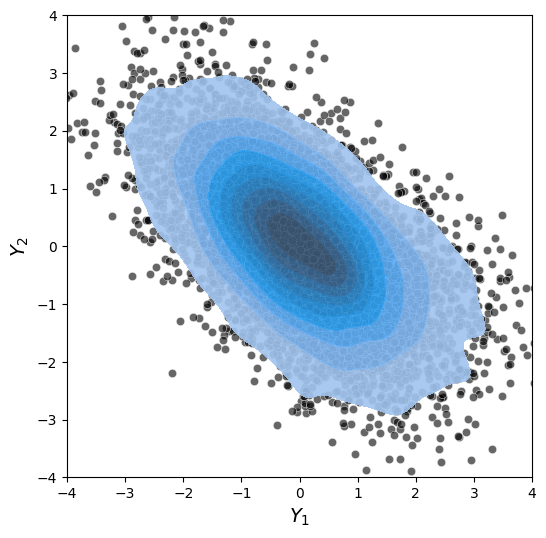

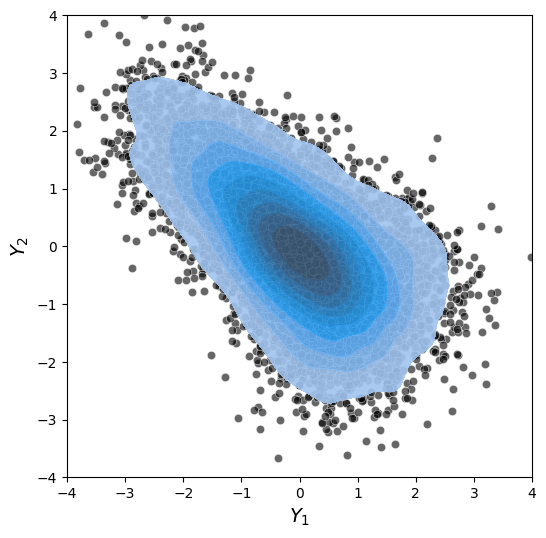

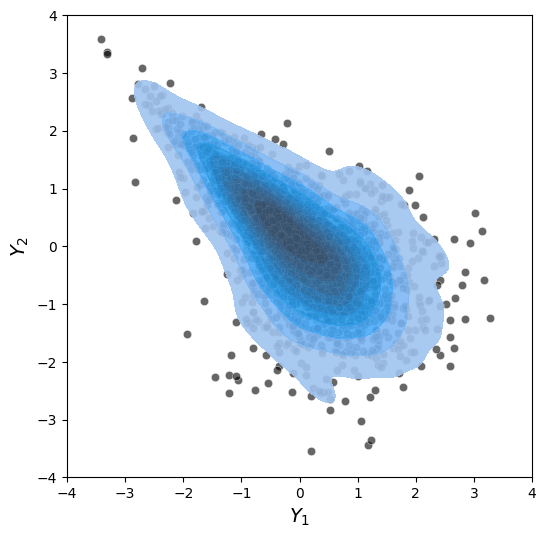

In [17]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


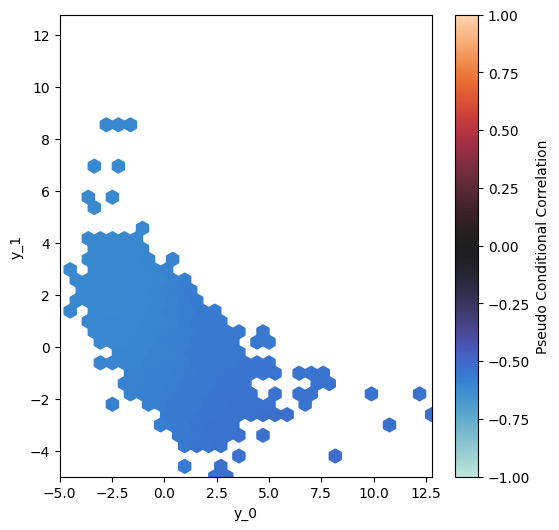

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


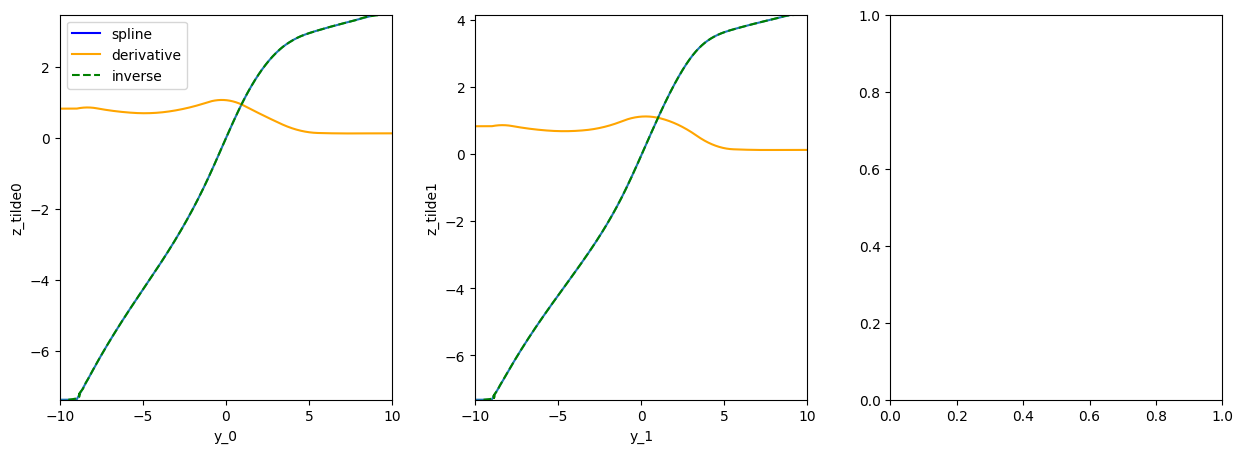

In [20]:
model.plot_splines(layer_type="transformation")

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


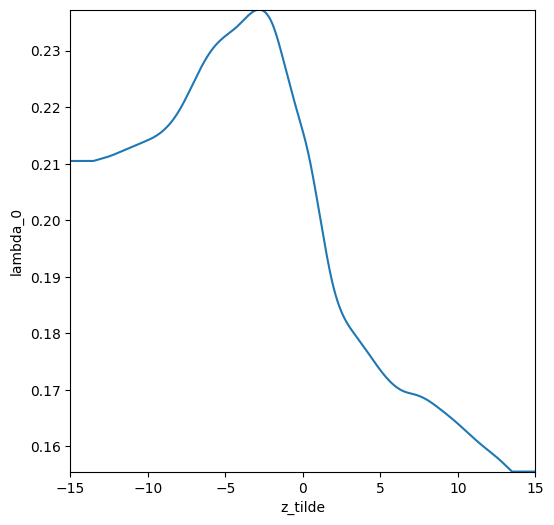

In [21]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


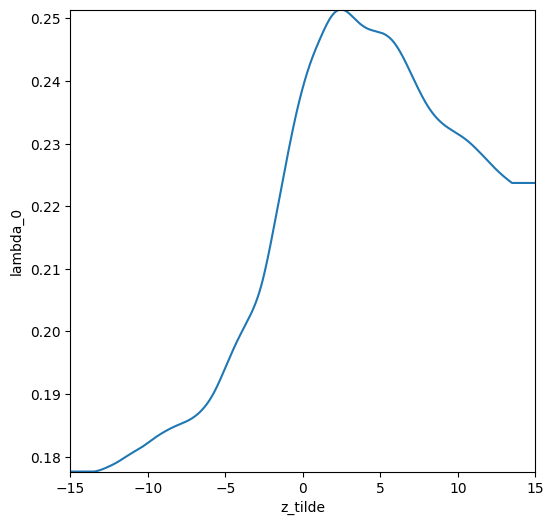

In [22]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


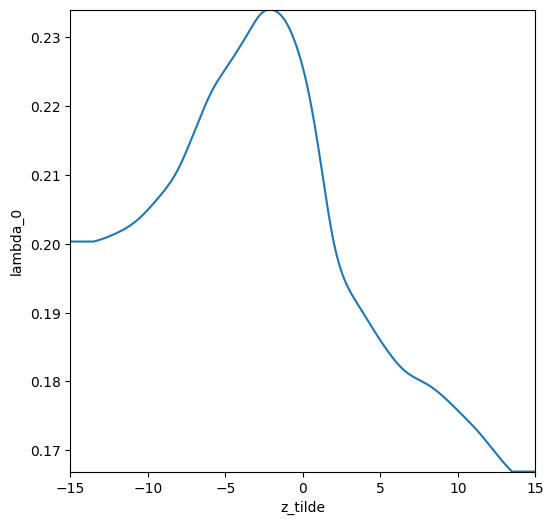

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)